# Unsupervised anomaly detection (fraud) algorithm


The data can be found here: https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-Data/rgy2-tti8

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
import os

os.chdir("/content/drive/MyDrive/DSO562")

In [ ]:
from datetime import datetime
start_time = datetime.now()

from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

print('LOAD DURATION:',datetime.now() - start_time) # about 6 seconds

LOAD DURATION: 0:00:02.456377


In [ ]:
%%time
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

CPU times: user 5.01 s, sys: 966 ms, total: 5.98 s
Wall time: 6.28 s


(1070994, 32)

In [ ]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [ ]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Remove some benign properties that we aren't interested in
There are certainly better ways to do this, and this important step can/should be improved.

In [ ]:
# first look at the most frequent owners
data['OWNER'].value_counts().head(20).index.tolist()


['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

NEW Process for removing government and city buildings

In [ ]:
#UPDATED CODE
#created a search list of words that are common in government or city owned building owner names
search_str = 'department|preservat|transportat|board of|recreation|environment|nyc dept|the port of|city and|ny state|united states|nys dept|residential|housing|pub works|government|association|bank nationa|new york city|new york state|DCAS|NYCTA|MTA|GOVT'
search_terms = search_str.split('|')

In [ ]:
#UPDATED CODE
#created removal list of all values that contain words in the government/city list
remove = data.loc[data['OWNER'].str.contains(search_str, case=False, na=False)]
remove_list = remove['OWNER'].tolist()
remove_list[:20]

['U S GOVT LAND & BLDGS',
 'U S GOVT LAND & BLDGS',
 'DEPARTMENT OF BUSINES',
 'PARKS AND RECREATION',
 'PARKS AND RECREATION',
 'PARKS AND RECREATION',
 'U S GOVERNMENT OWNRD',
 'PARKS AND RECREATION',
 'CNY/NYCTA',
 'PARKS AND RECREATION',
 'DEPARTMENT OF BUSINES',
 'DEPARTMENT OF BUSINES',
 'NEW YORK STATE DEPART',
 'WAY BROADCASTING INC',
 'THE BOARD OF MANAGERS',
 'NEW YORK STATE OWNED',
 'NEW YORK CITY TRANSIT',
 'THE BOARD OF MANAGERS',
 'PARKS AND RECREATION',
 'DEPT OF TRANSPORTATIO']

In [ ]:
property_data = data[~data['OWNER'].isin(remove_list)].reset_index(drop=True)
property_data.shape

(1043806, 32)

In [ ]:
data.shape

(1070994, 32)

In [ ]:
#removed an additional 2,710 government and city records
len(data) - len(property_data)

27188

In [ ]:
numrecs = len(property_data)

## Fill in missing ZIP

In [ ]:
# How many zips are missing? Replace NAN with 0 and count them.
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

21664

In [ ]:
# Assume the data is already sorted by zip. If a zip is missing,
# and the before and after zips are the same, fill in the zip with that value
for i in range(len(missing_zips)):
    if(property_data.loc[missing_zips[i]+1,'ZIP'] == property_data.loc[missing_zips[i]-1,'ZIP']):
        property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [ ]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

10210

In [ ]:
# For the remaining missing zips, just fill in with the previous record's zip.
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [ ]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

## Calculate means for AVTOT, AVLAND, FULLVAL by taxclass, avoiding the records with zeros

In [ ]:
property_data['FULLVAL'].replace('NaN',0)
temp =property_data[property_data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.699346e+05
1A    3.353364e+05
1B    4.243277e+05
1C    7.615359e+05
1D    2.233614e+07
2     7.919847e+05
2A    8.635656e+05
2B    1.256927e+06
2C    7.563534e+05
3     9.435300e+04
4     2.831080e+06
Name: FULLVAL, dtype: float64


In [ ]:
property_data['AVLAND'].replace('NaN',0)
temp_avland = property_data[property_data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()

In [ ]:
property_data['AVTOT'].replace('NaN',0)
temp_avtot = property_data[property_data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()

## Substituting decent values for AVTOT, AVLAND, FULLVAL from averages by taxclass

In [ ]:
%%time
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0)&(property_data['TAXCLASS']==index),'FULLVAL']=mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0)&(property_data['TAXCLASS']==index),'AVLAND']=mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0)&(property_data['TAXCLASS']==index),'AVTOT']=mean_avtot[index]

CPU times: user 2.53 s, sys: 7.05 ms, total: 2.54 s
Wall time: 2.49 s


In [ ]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,3,8,9,10,11
BBLE,1000020001,1000030010,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,2,3,4,4,4
LOT,1,10,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,DEPT OF GENERAL SERVI,DEPT RE-CITY OF NY,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,Y7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,709,362,0,0,0


## Fill in the missing STORIES

In [ ]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

43593

In [ ]:
temp['TAXCLASS'].value_counts()

1B    19066
4     17652
2      3425
3      2364
1       879
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [ ]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111264
1A     1.657169
1B     4.000000
1C     3.052748
1D     1.068966
2     16.394697
2A     2.843268
2B     3.999094
2C     4.758238
3           NaN
4      5.506605
Name: STORIES, dtype: float64


In [ ]:
temp.head().transpose()

,59,60,61,62,64
RECORD,66,67,68,69,71
BBLE,1000051004,1000051005,1000051006,1000051007,1000060001
BORO,1,1,1,1,1
BLOCK,5,5,5,5,6
LOT,1004,1005,1006,1007,1
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT,THE CITY OF NEW YORK
BLDGCL,R5,R5,R5,R5,Q9
TAXCLASS,4,4,4,4,4
LTFRONT,0,0,0,0,234


In [ ]:
len(property_data[property_data["STORIES"]==0])

0

In [ ]:
property_data['STORIES']=property_data['STORIES'].fillna(value =0)
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES']==0)&(property_data['TAXCLASS']==index),'STORIES']=mean_stories[index]

In [ ]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,3,8,9,10,11
BBLE,1000020001,1000030010,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,2,3,4,4,4
LOT,1,10,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,DEPT OF GENERAL SERVI,DEPT RE-CITY OF NY,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,Y7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,709,362,0,0,0


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [ ]:
# Because these 4 fields do not have NAs, we just need to replace 0s.
# We think zero and 1 are invalid values for these fields, so replace them wiht NA.
# Calculate groupwise average. Replace 0 and 1's by NAs so they are not counted in calculating mean.
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

# Calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

# Now impute values with the average for that record's TAXCLASS
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

In [ ]:
mean_LTFRONT

TAXCLASS
1      30.941132
1A     51.139141
1B     47.445272
1C     27.250825
1D    338.275862
2     111.538863
2A     25.923763
2B     27.201575
2C     30.185947
3     132.045267
4      82.728881
Name: LTFRONT, dtype: float64

In [ ]:
mean_LTDEPTH

TAXCLASS
1      99.278713
1A     90.106457
1B    105.157817
1C     96.778878
1D    497.827586
2     130.653743
2A     97.289090
2B     95.727273
2C     95.723510
3     250.320988
4     124.218013
Name: LTDEPTH, dtype: float64

In [ ]:
mean_BLDFRONT

TAXCLASS
1     21.404069
1A    25.025874
1B    39.500000
1C    23.367589
1D    19.586207
2     91.479061
2A    22.986195
2B    25.986798
2C    28.044874
3           NaN
4     61.799626
Name: BLDFRONT, dtype: float64

In [ ]:
mean_BLDDEPTH

TAXCLASS
1      41.561682
1A     44.950435
1B     82.666667
1C     60.094862
1D     36.862069
2     103.838698
2A     62.433850
2B     66.499446
2C     69.001425
3      20.000000
4      86.034475
Name: BLDDEPTH, dtype: float64

In [ ]:
data = property_data.copy()
data.shape

(1043806, 32)

In [ ]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [ ]:
# convert ZIP to a string rather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [ ]:
data.count()

RECORD      1043806
BBLE        1043806
BORO        1043806
BLOCK       1043806
LOT         1043806
EASEMENT       3363
OWNER       1012061
BLDGCL      1043806
TAXCLASS    1043806
LTFRONT     1043806
LTDEPTH     1043806
EXT          352815
STORIES     1041442
FULLVAL     1043806
AVLAND      1043806
AVTOT       1043806
EXLAND      1043806
EXTOT       1043806
EXCD1        623002
STADDR      1043308
ZIP         1043806
EXMPTCL       10197
BLDFRONT    1041442
BLDDEPTH    1043806
AVLAND2      265759
AVTOT2       265765
EXLAND2       80957
EXTOT2       117837
EXCD2         92837
PERIOD      1043806
YEAR        1043806
VALTYPE     1043806
zip3        1043806
dtype: int64

In [ ]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


### Now build variables that try to find properties that are unusual in ways we're interested in

In [ ]:
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * data['STORIES']

In [ ]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [ ]:
# add in the inverse of all the 9 primary variables
epsilon = .01
for col in data.columns[36:]:
    data[col+'inv'] = 1/(data[col] + epsilon)

In [ ]:
vars18 = ['r1','r2','r3','r4','r5','r6','r7','r8','r9',
          'r1inv','r2inv','r3inv','r4inv','r5inv','r6inv','r7inv','r8inv','r9inv']
zip5_mean = data.groupby('ZIP')[vars18].mean()
taxclass_mean = data.groupby('TAXCLASS')[vars18].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
rsuffix = ['_zip5', '_taxclass']
for var in vars18:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [ ]:
data['value_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])
data['value_ratio'] = data['value_ratio']/data['value_ratio'].mean()
data['value_ratio'] = np.where(data['value_ratio'] < 1, 1/(data['value_ratio']+epsilon), data['value_ratio'])

In [ ]:
data.head().transpose()

,0,1,2,3,4
RECORD,3,8,9,10,11
BBLE,1000020001,1000030010,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,2,3,4,4,4
LOT,1,10,1001,1002,1003
...,...,...,...,...,...
r6inv_taxclass,0.00425,0.000315,0.057535,0.039863,0.037881
r7inv_taxclass,0.010147,0.006058,0.006921,0.004789,0.002576
r8inv_taxclass,0.01137,0.00089,0.004012,0.002776,0.001493
r9inv_taxclass,0.00731,0.000572,0.042936,0.029723,0.015994


In [ ]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize',
       'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r1inv',
       'r2inv', 'r3inv', 'r4inv', 'r5inv', 'r6inv', 'r7inv', 'r8inv', 'r9inv',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1inv_zip5', 'r2inv_zip5',
       'r3inv_zip5', 'r4inv_zip5', 'r5inv_zip5', 'r6inv_zip5', 'r7inv_zip5',
       'r8inv_zip5', 'r9inv_zip5', 'r1_taxclass', 'r2_taxclass', 'r3_taxclass',
       'r4_taxclass', 'r5_taxclass', 'r6_taxclass', 'r7_taxclass',
       'r8_taxclass', 'r9_taxclass', 'r1inv_taxclass', 'r2inv_taxclass',
       'r3inv_taxclass',

NEW Variables



In [ ]:
#created a variable to investigate the ratio of building size to lot size
#the ratio theoretically should be < 1 since you would expect the lot to be bigger than the building

data['lot_building_ratio'] = data['bldsize']/data['ltsize']

In [ ]:
#variable to investigate whether the market value of the record differs from the average market value for that zip3
grouped = data.groupby('zip3')['FULLVAL'].mean()
data['market_value_zip3_ratio'] = data['FULLVAL']/data['zip3'].map(grouped)

In [ ]:
#variable to investigate whether the market value of the record differs from the average market value for that zip5
grouped_zip5 = data.groupby('ZIP')['FULLVAL'].mean()
data['market_value_zip5_ratio'] = data['FULLVAL']/data['ZIP'].map(grouped)

In [ ]:
#Inverse verstions of market value zip ratios
data['inverse_market_value_zip3_ratio'] = 1/(data['market_value_zip3_ratio']+epsilon)
data['inverse_market_value_zip3_ratio'] = 1/(data['market_value_zip5_ratio']+epsilon)

In [ ]:
save_record = data['RECORD']
save_record.head()

0     3
1     8
2     9
3    10
4    11
Name: RECORD, dtype: int64

In [ ]:
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1043806, 60)

In [ ]:
data.head().transpose()

,0,1,2,3,4
r1,261.796157,438.555420,383.865497,554.758520,1031.487900
r2,261.796157,3345.636385,741.929170,1072.228506,1993.643522
r3,87.265386,1115.212128,14.838583,21.444570,39.872870
r4,97.551991,172.768986,61.898324,89.454912,94.147598
r5,97.551991,1318.014049,119.636103,172.897042,181.966991
r6,32.517330,439.338016,2.392722,3.457941,3.639340
r7,117.808271,197.349939,172.739484,249.641383,464.169555
r8,117.808271,1505.536373,333.868145,482.502922,897.139585
r9,39.269424,501.845458,6.677363,9.650058,17.942792
r1inv,0.003820,0.002280,0.002605,0.001803,0.000969


In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r1,1043806.0,213.386386,537.534468,3.892407e-04,76.227510,152.812344,243.007387,1.415540e+05
r2,1041442.0,539.069002,1626.621572,7.523183e-04,210.526316,500.742394,684.375000,1.156689e+06
r3,1041442.0,244.532772,586.915072,9.023443e-05,82.456140,238.888889,335.648148,2.275000e+05
r4,1043806.0,10.503476,77.623201,8.333333e-06,2.350381,4.592857,7.215143,2.557428e+04
r5,1041442.0,23.385939,661.106083,2.105470e-04,6.156000,14.951564,20.232955,5.018904e+05
r6,1041442.0,9.979817,223.728100,1.038033e-05,1.997769,7.137244,10.019137,1.123969e+05
r7,1043806.0,26.697164,205.337916,8.333333e-06,5.279118,8.570000,13.490749,6.604853e+04
r8,1041442.0,50.902462,1096.811189,3.062474e-04,17.416250,26.925641,35.883131,8.780136e+05
r9,1041442.0,18.892043,357.194126,6.049251e-05,7.052632,12.655729,17.518914,2.926712e+05
r1inv,1043806.0,0.083978,0.895396,7.064442e-06,0.004115,0.006544,0.013117,9.625342e+01


<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


CPU times: user 28.1 s, sys: 12.7 s, total: 40.8 s
Wall time: 42.2 s


/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


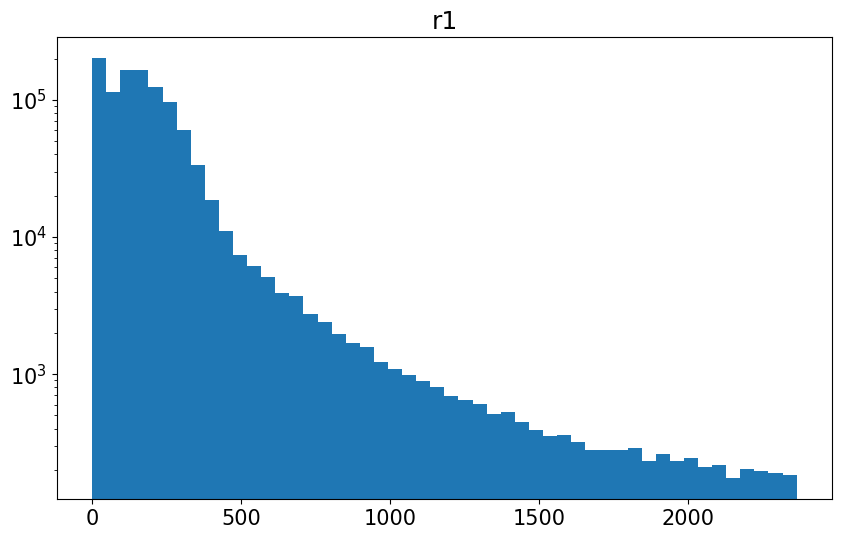

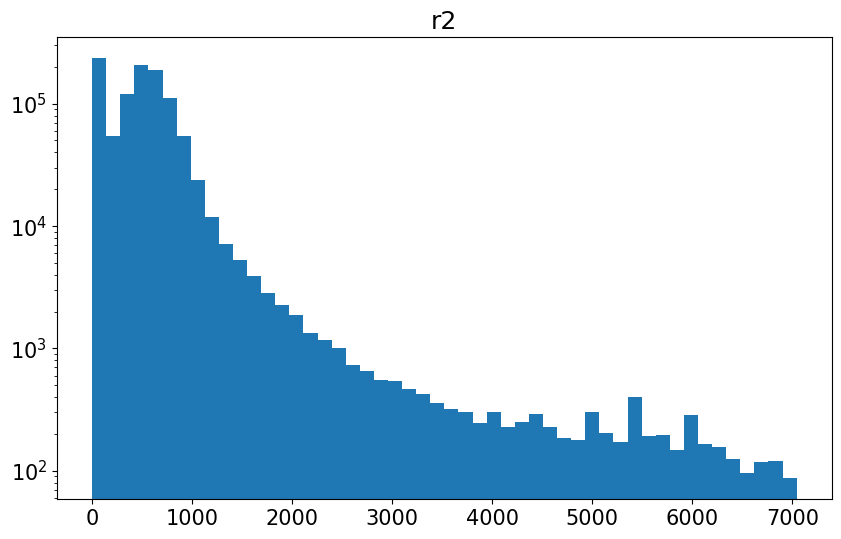

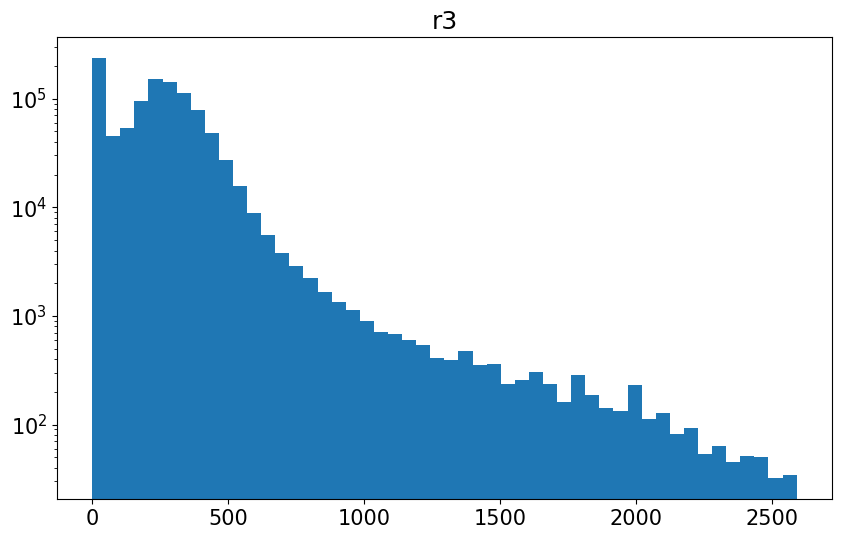

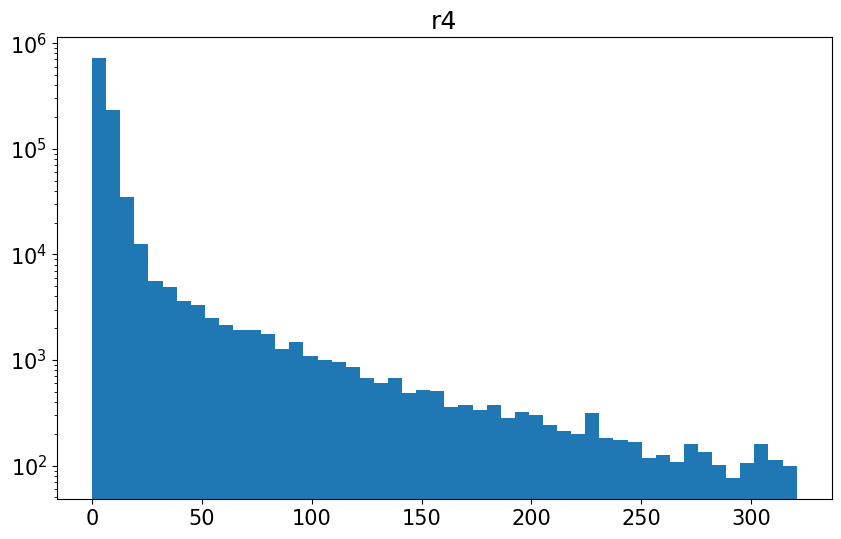

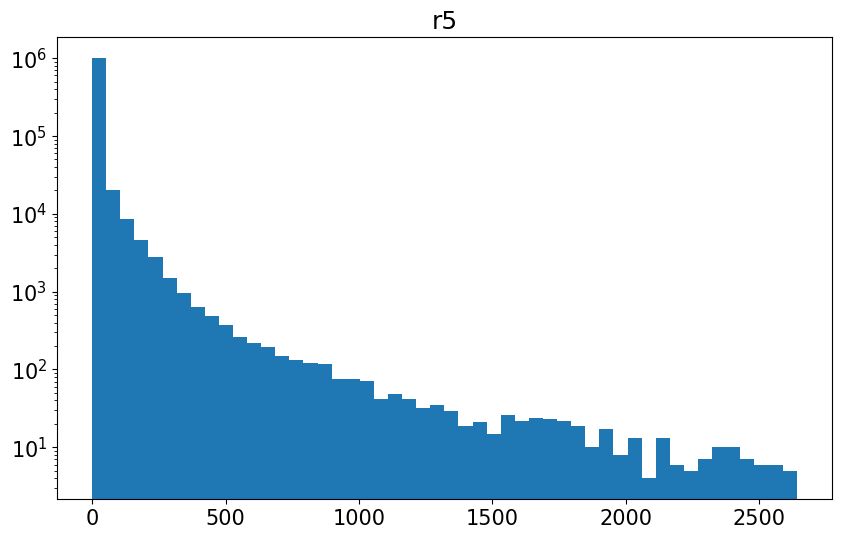

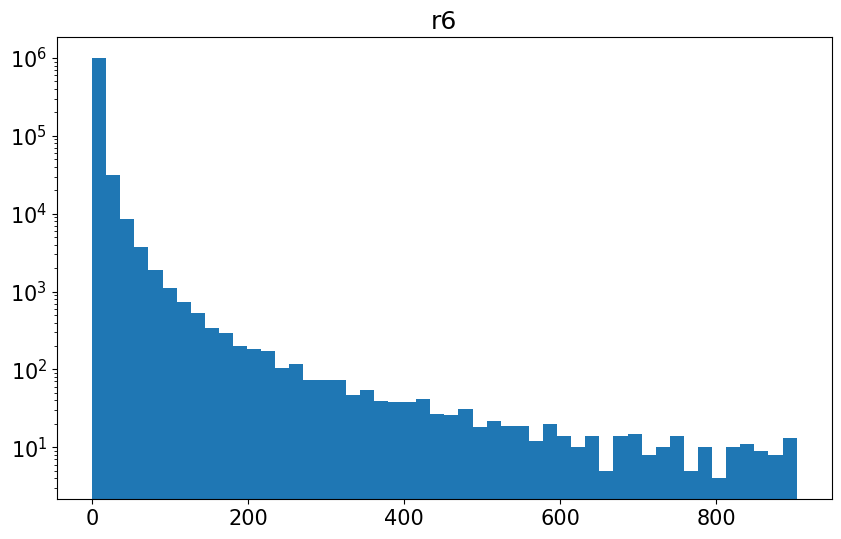

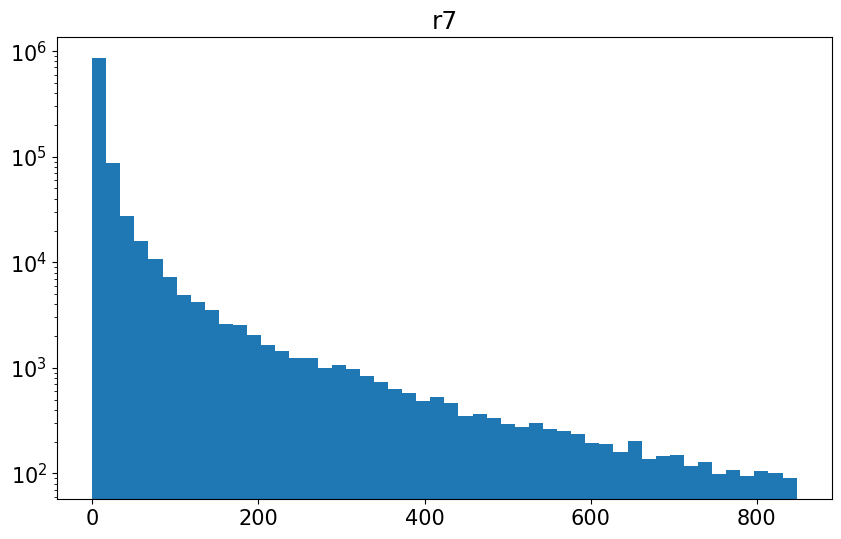

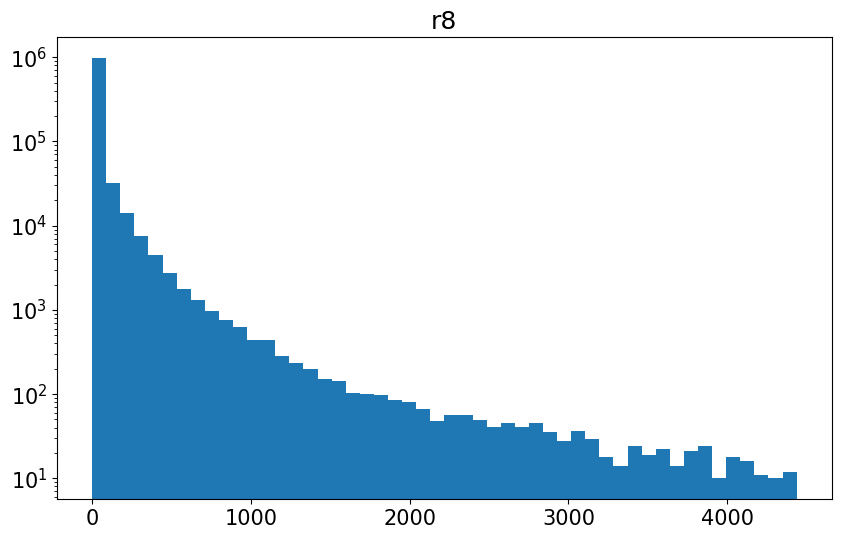

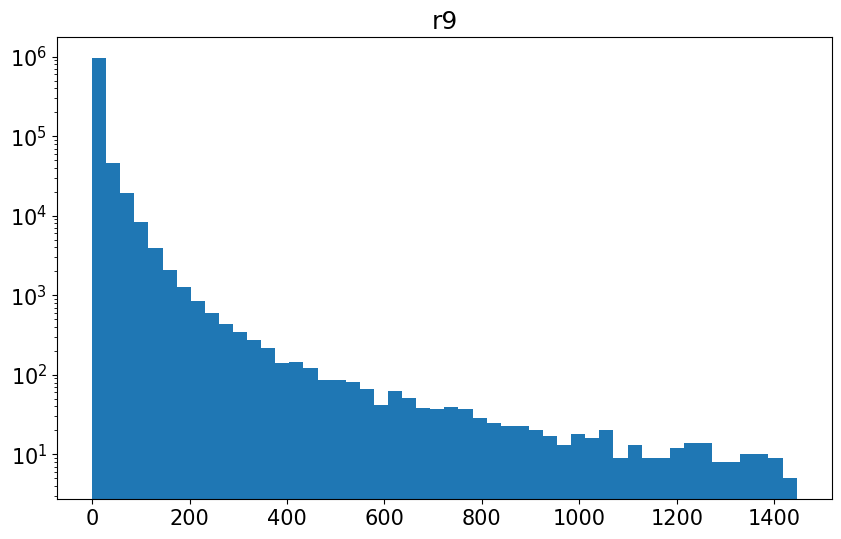

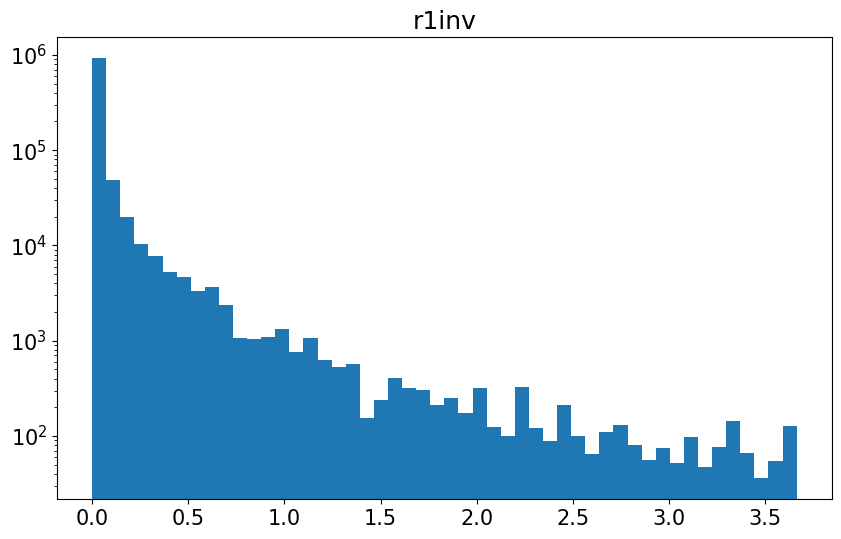

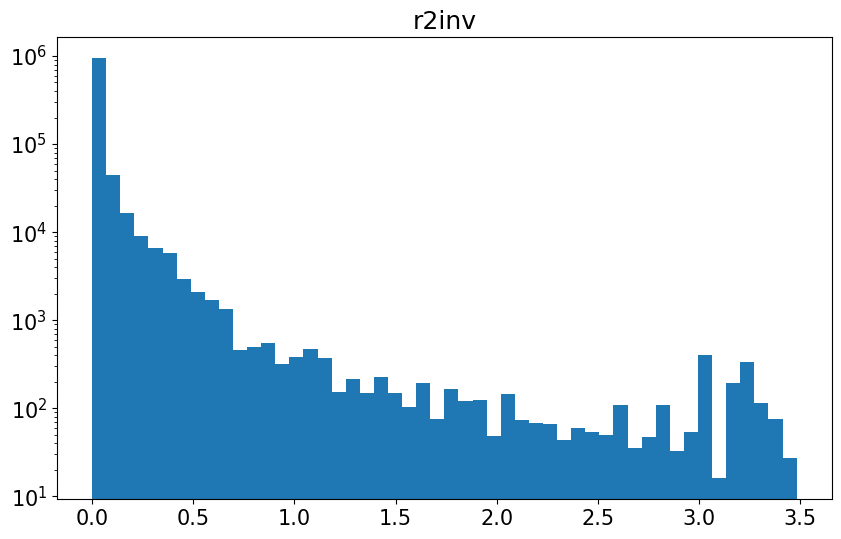

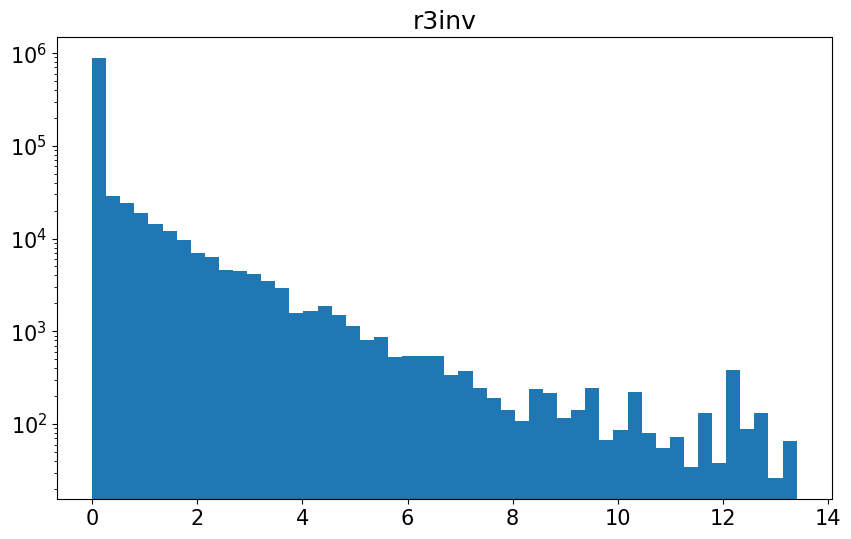

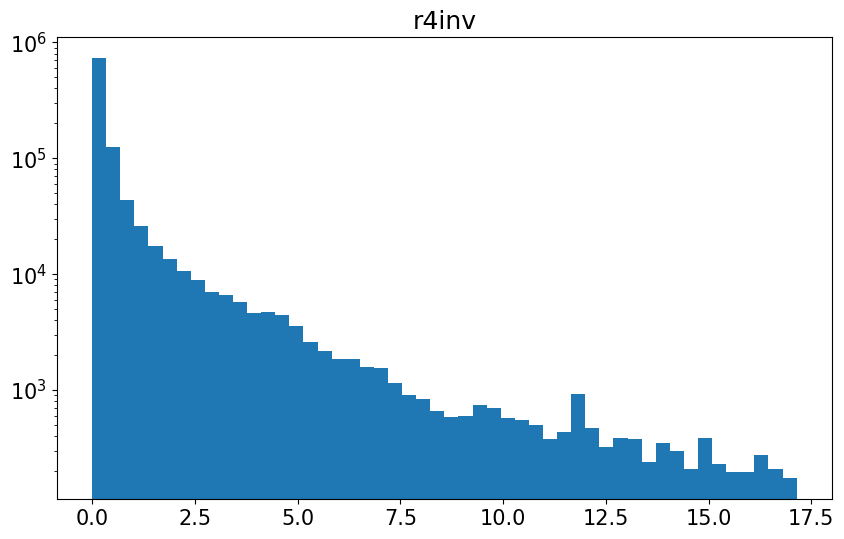

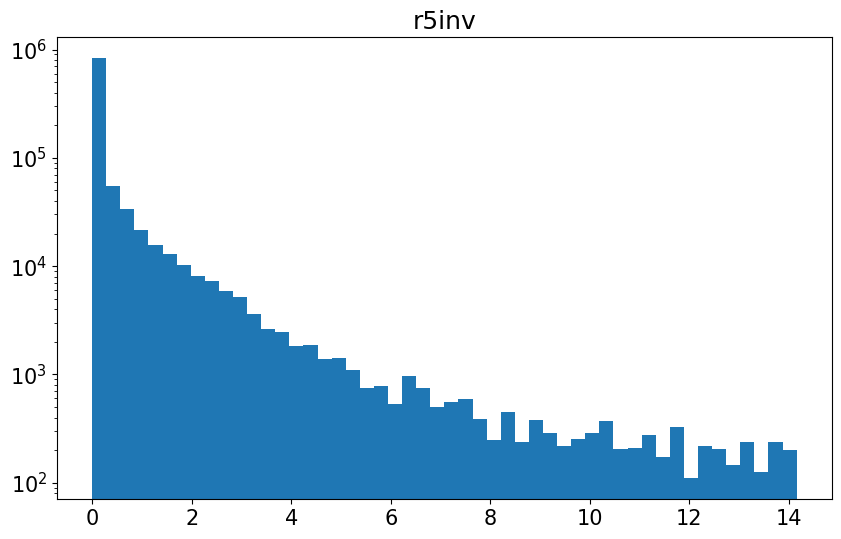

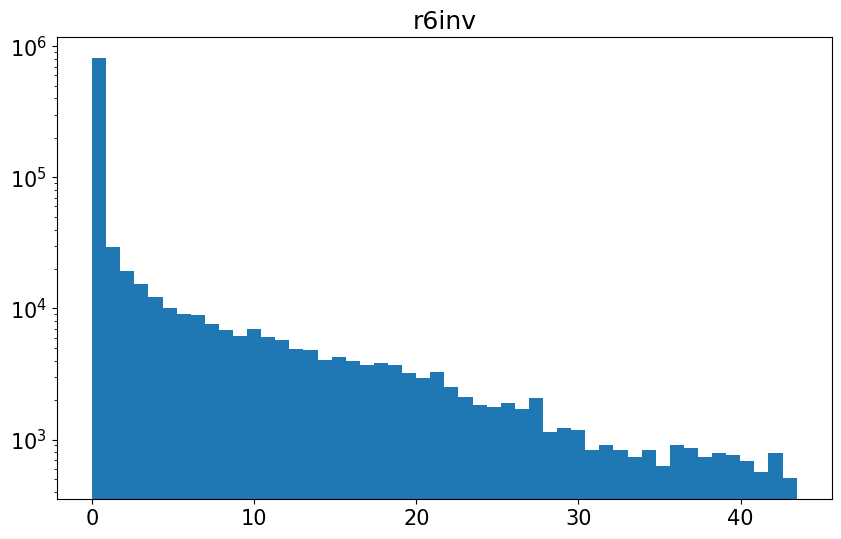

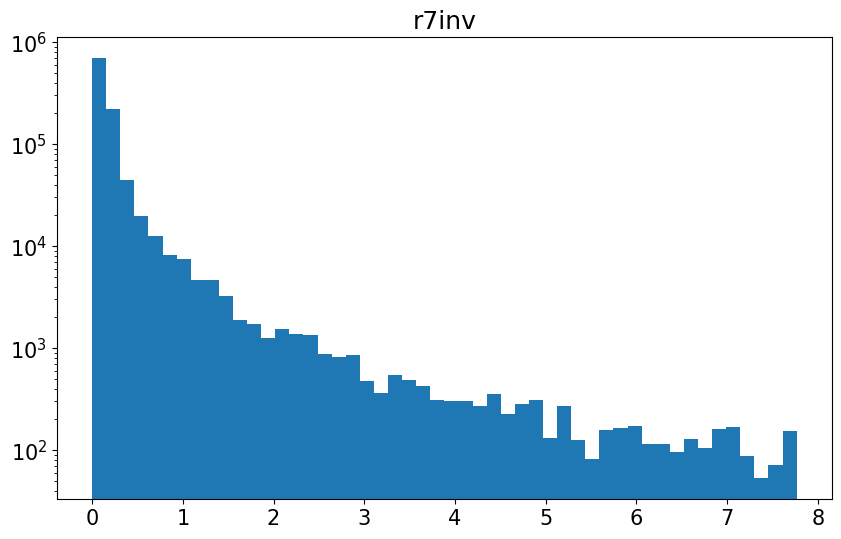

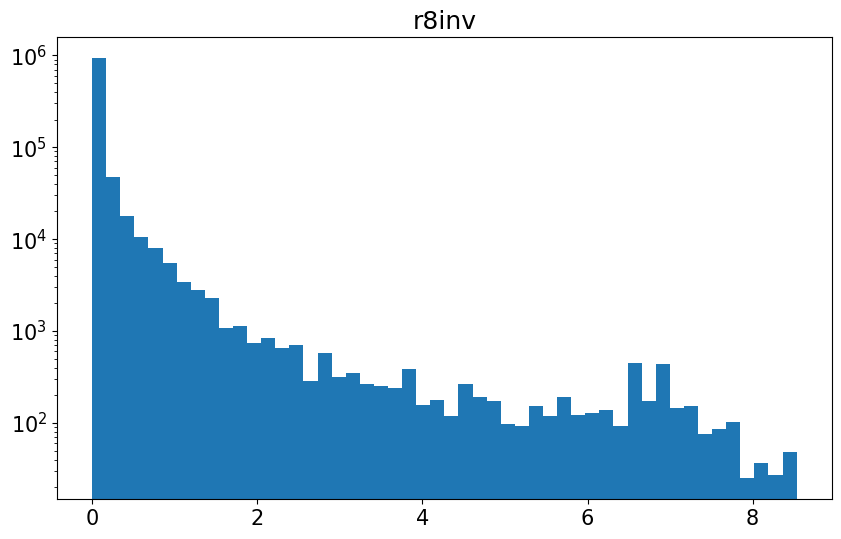

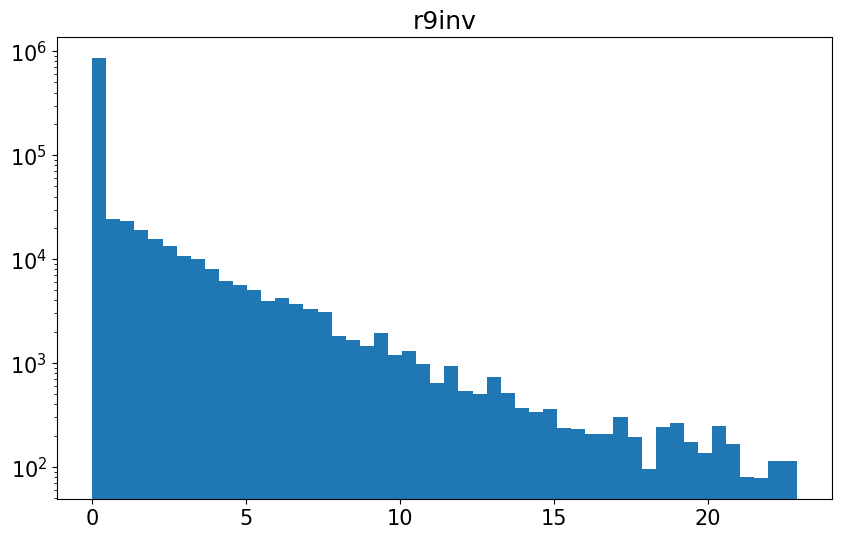

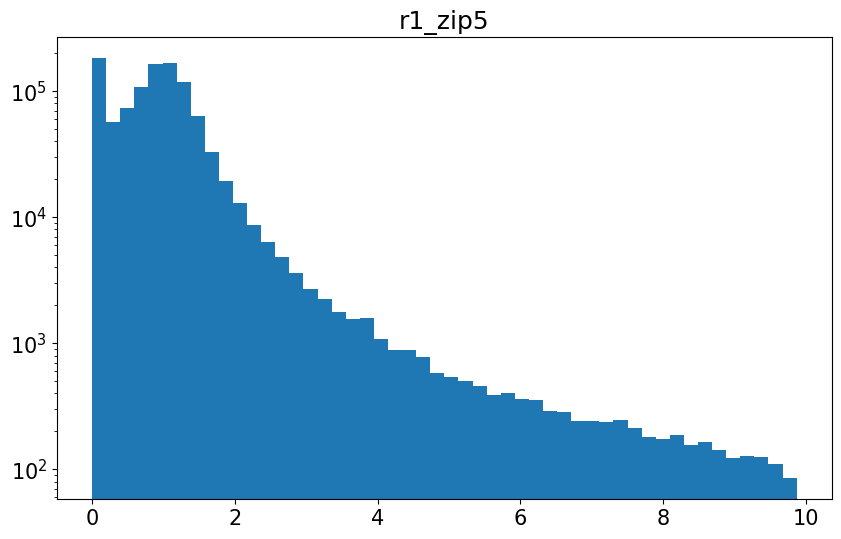

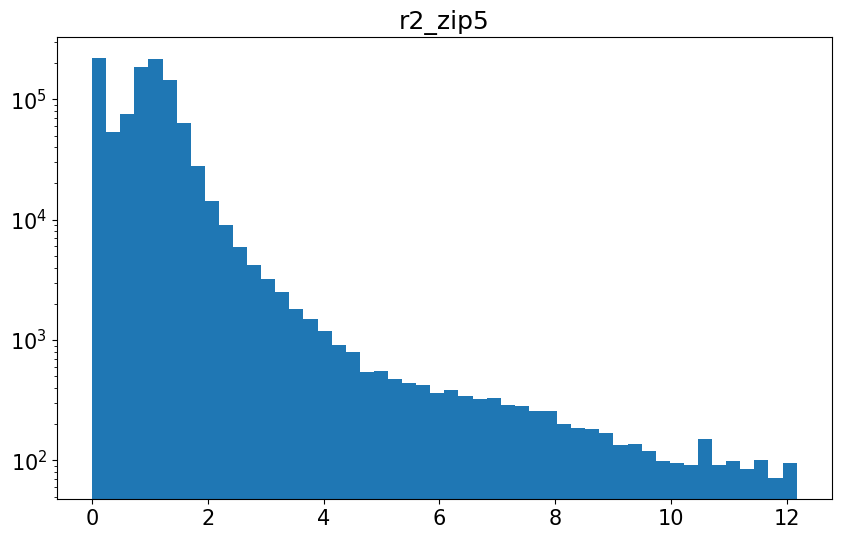

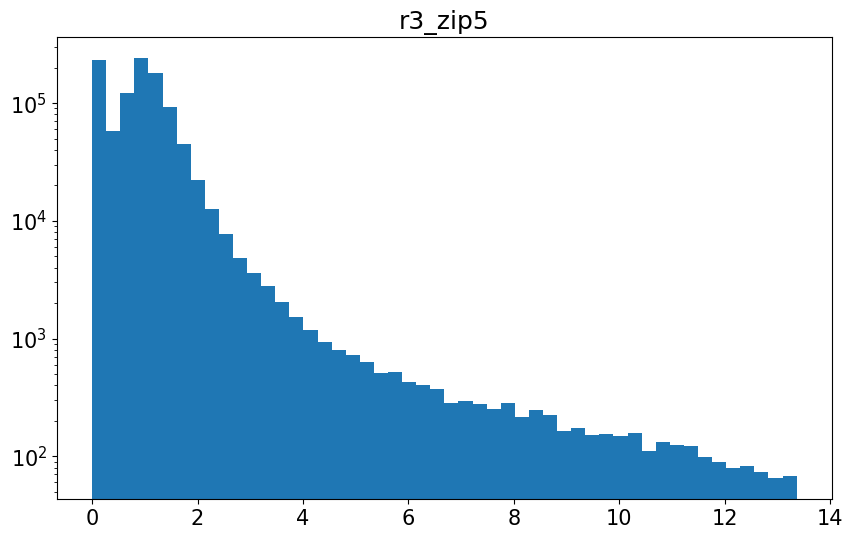

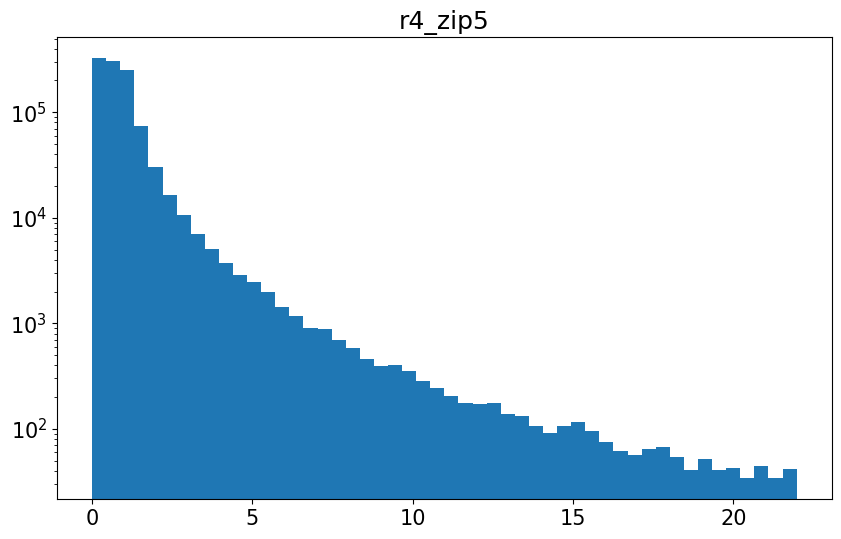

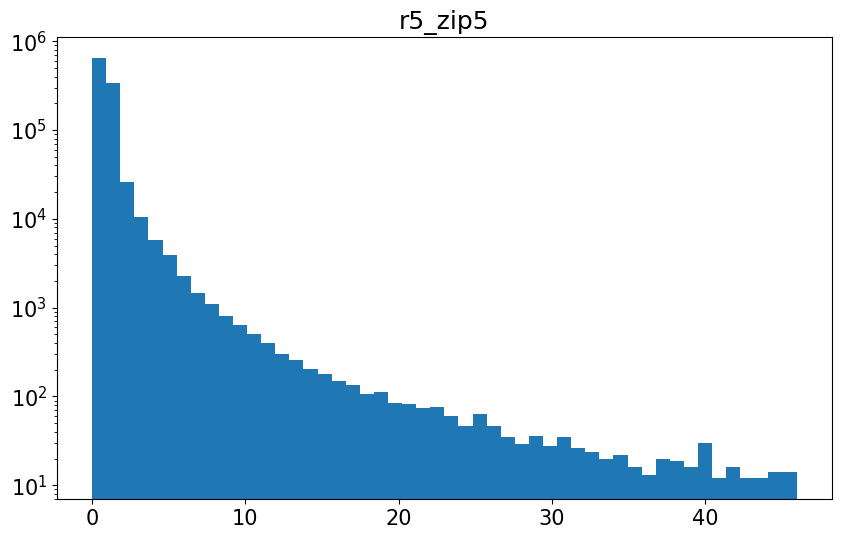

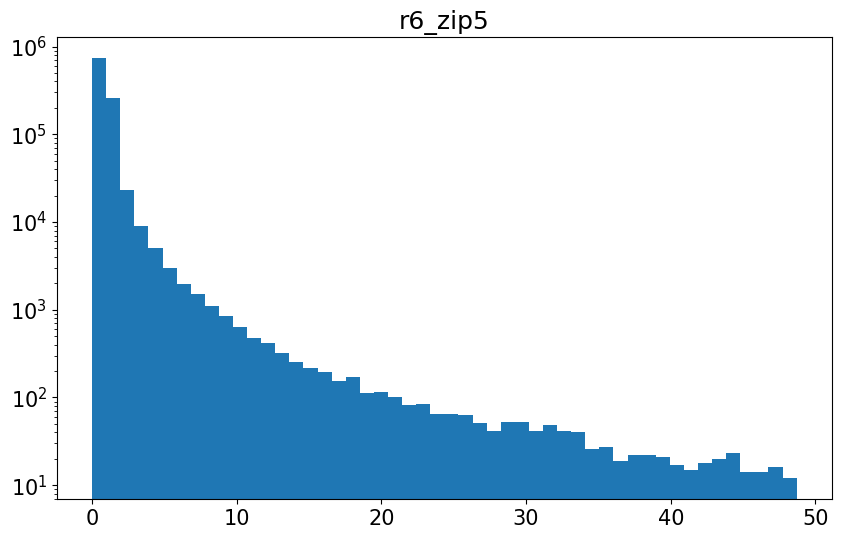

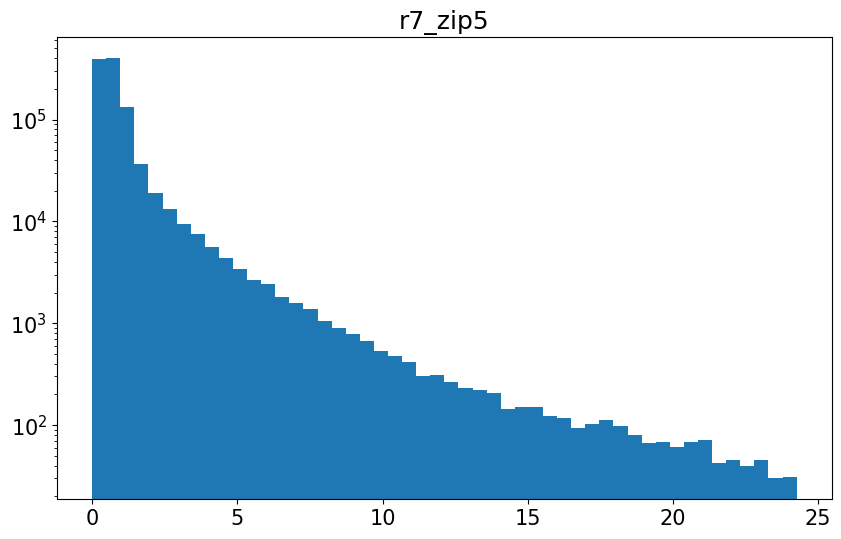

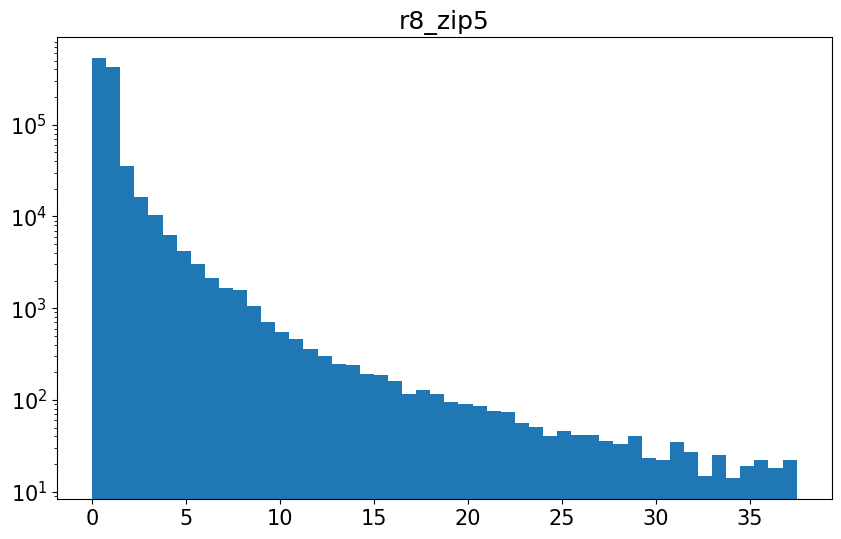

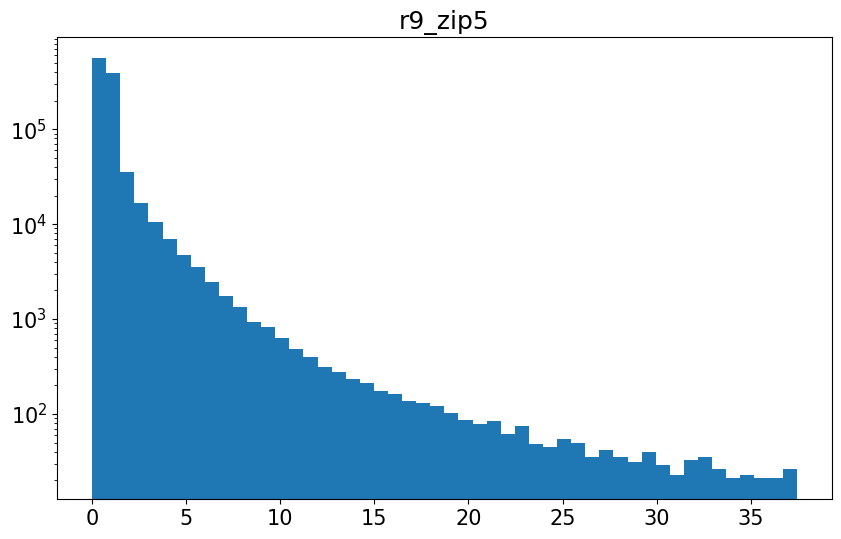

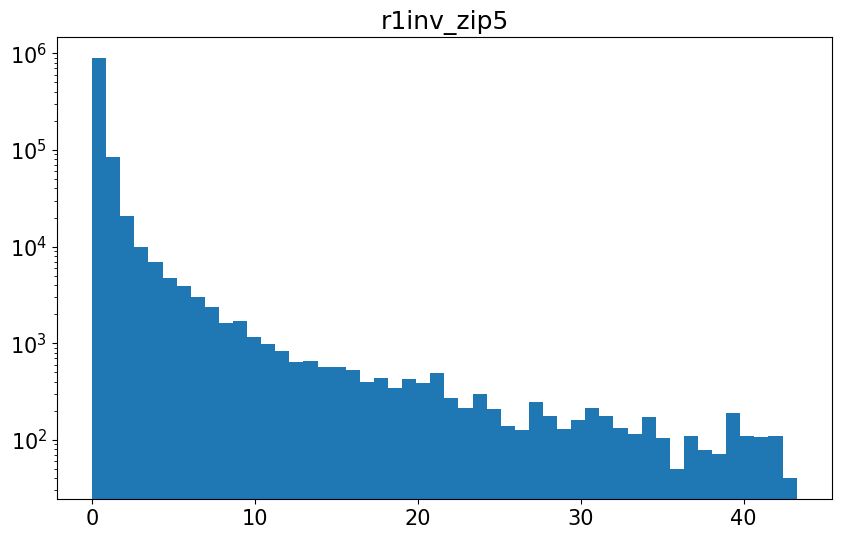

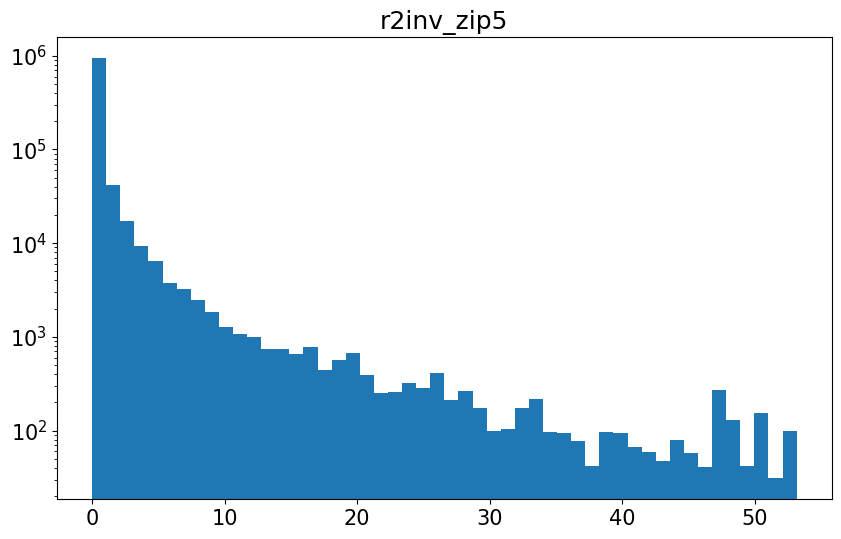

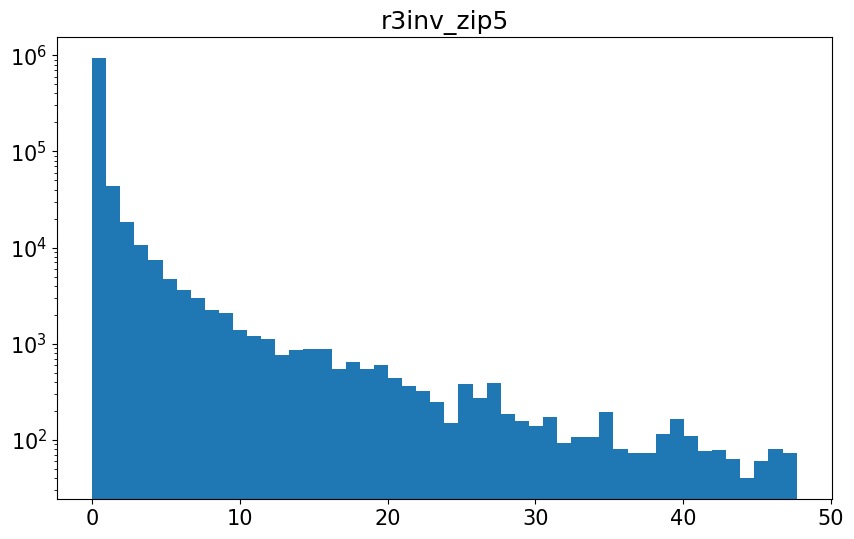

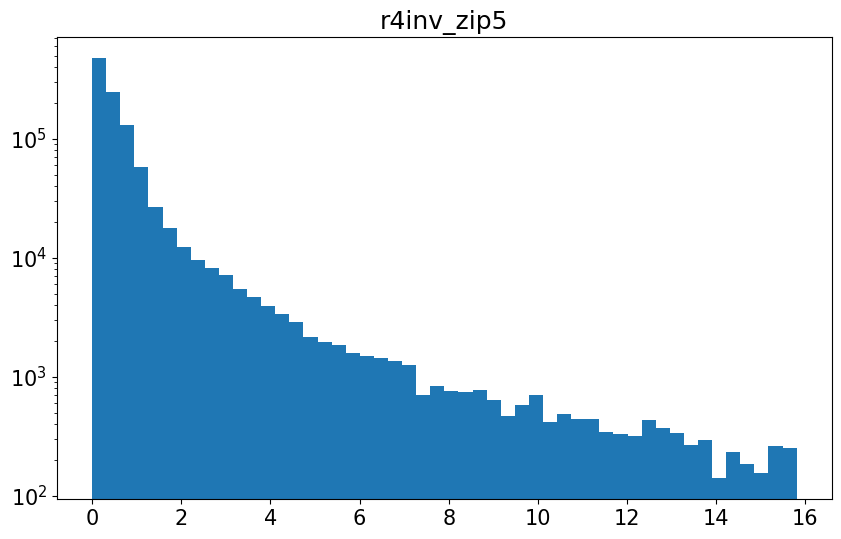

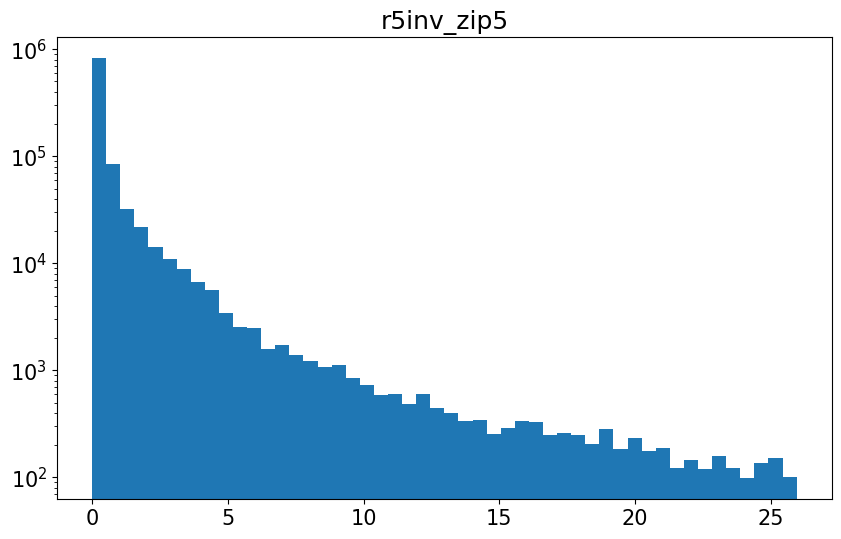

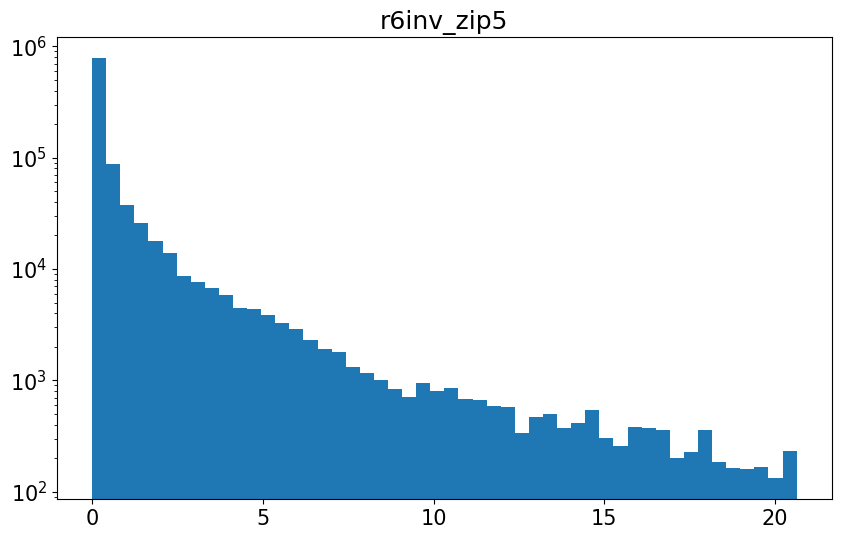

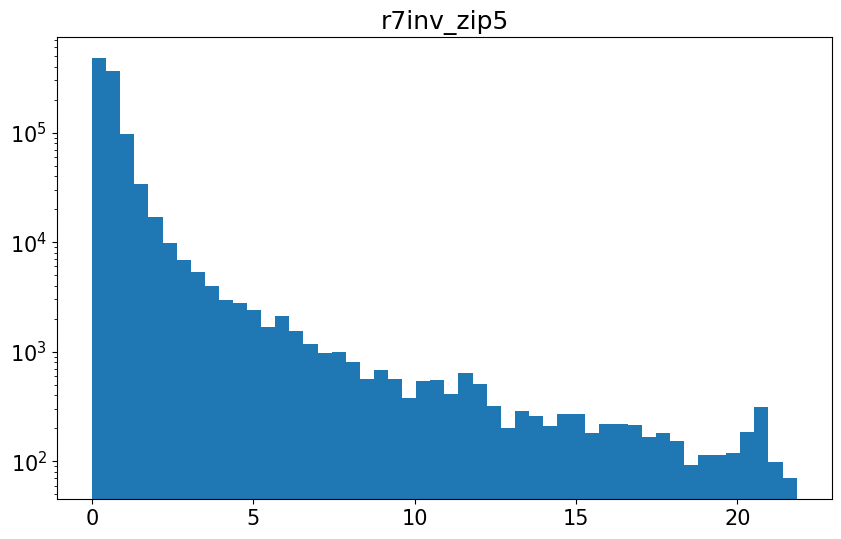

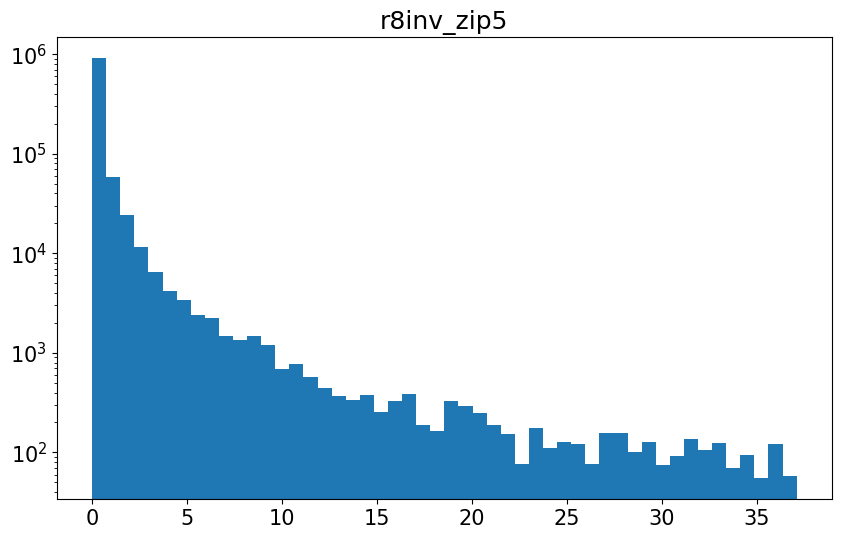

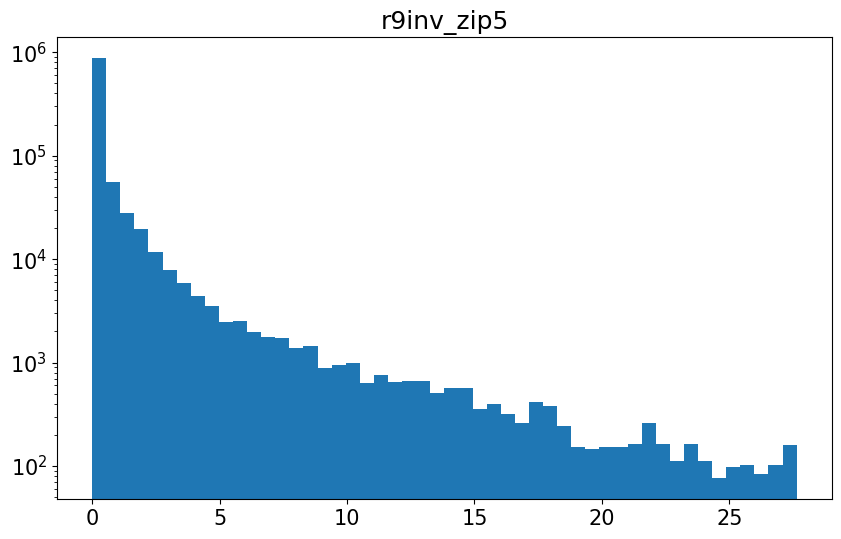

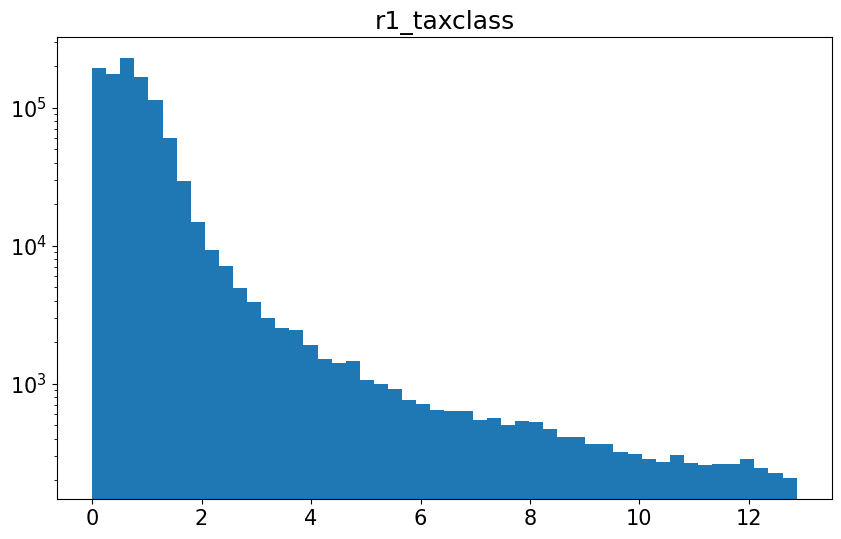

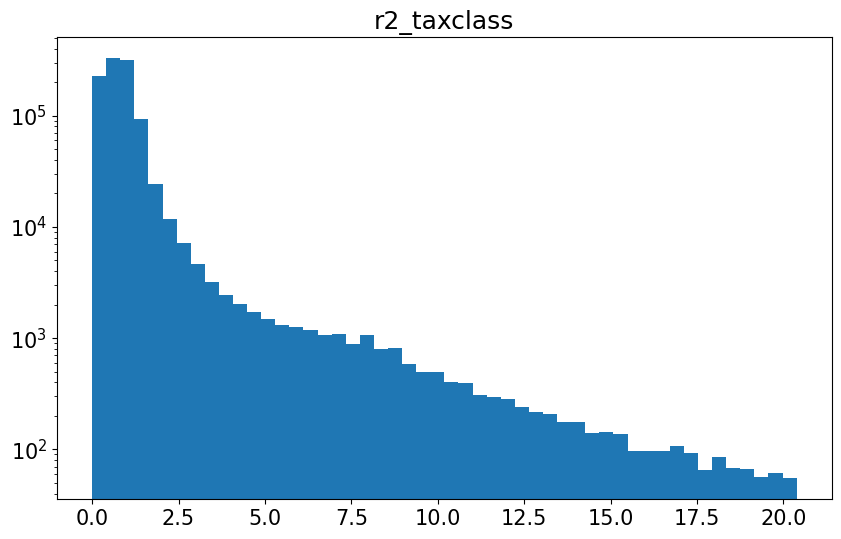

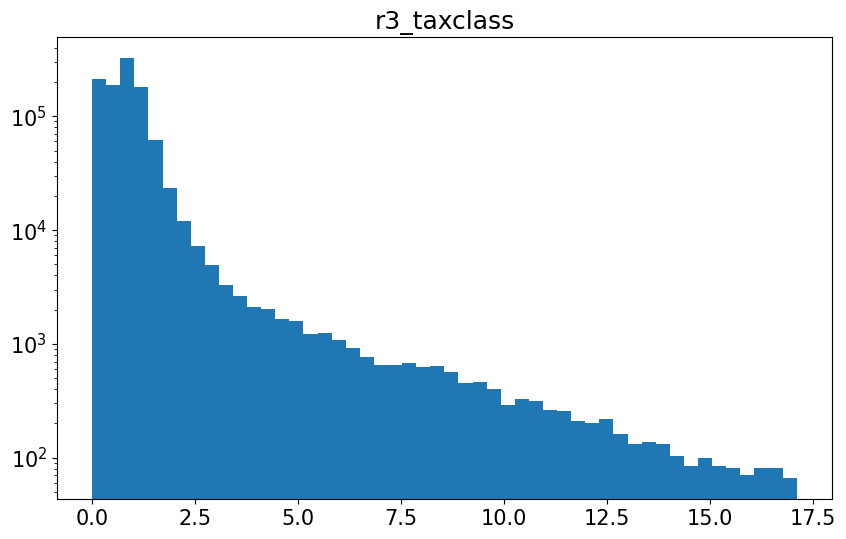

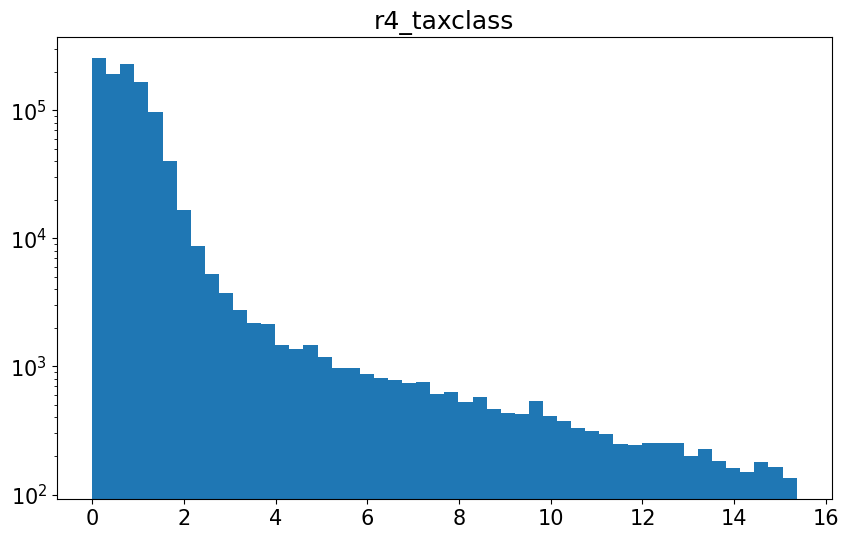

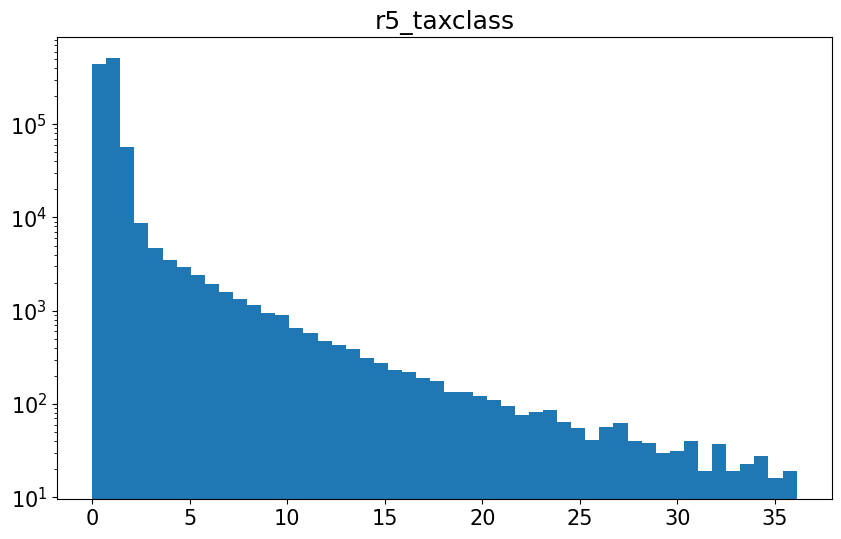

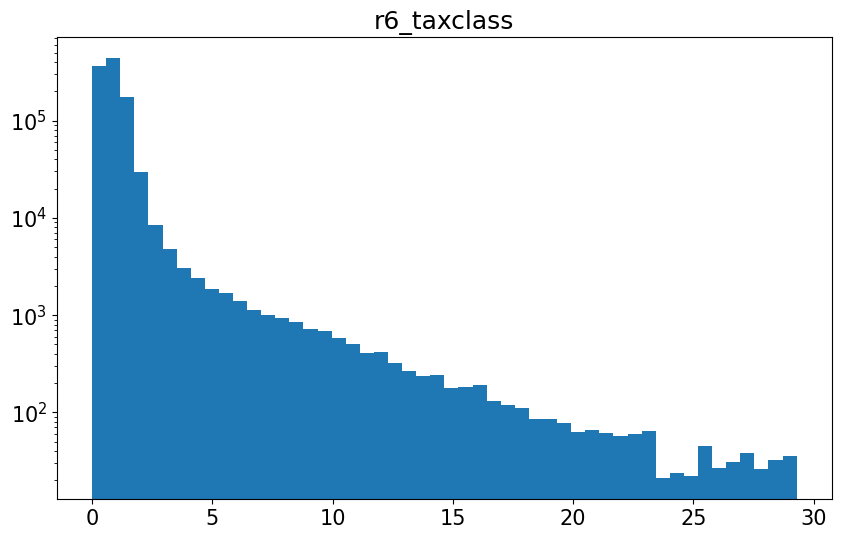

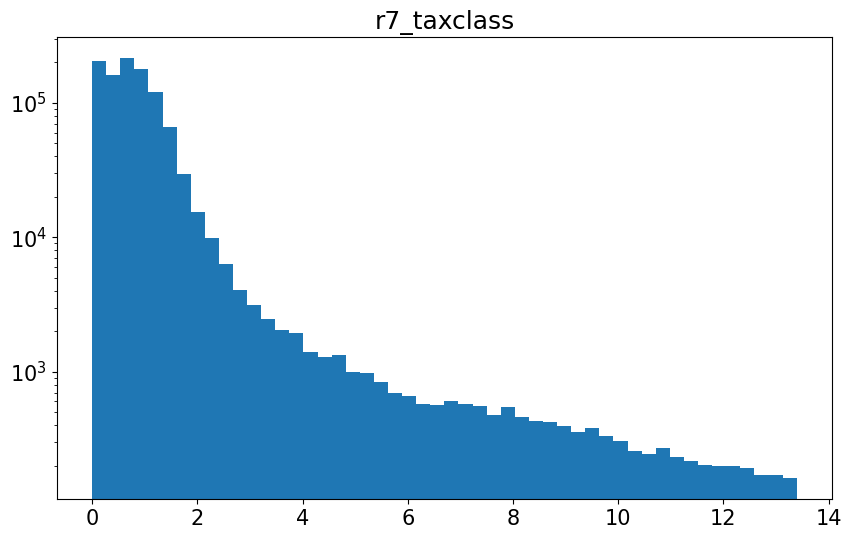

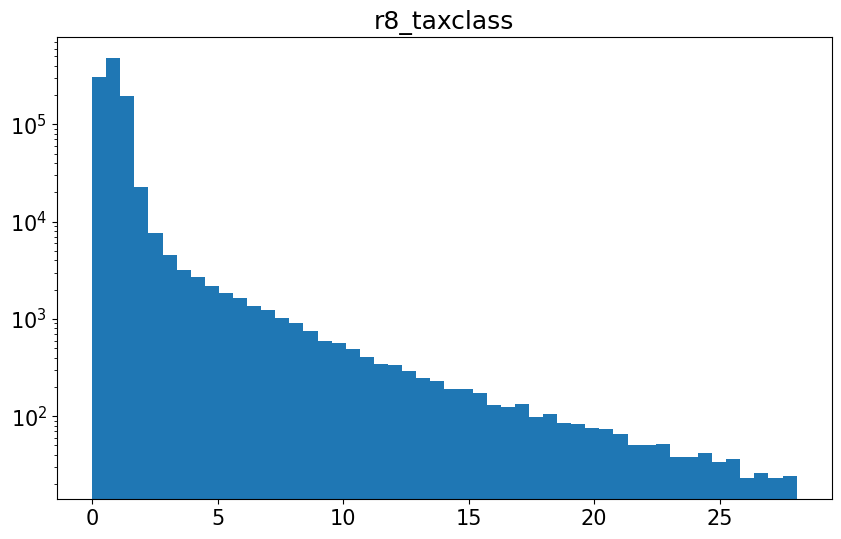

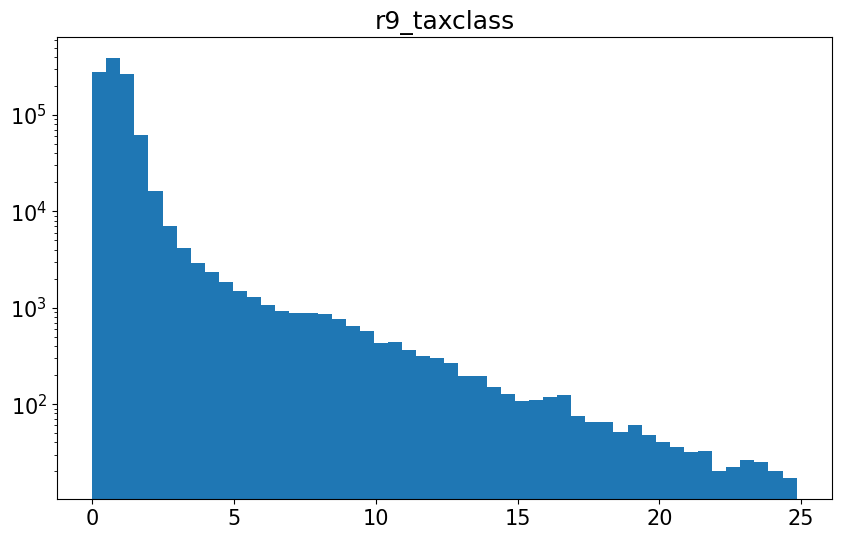

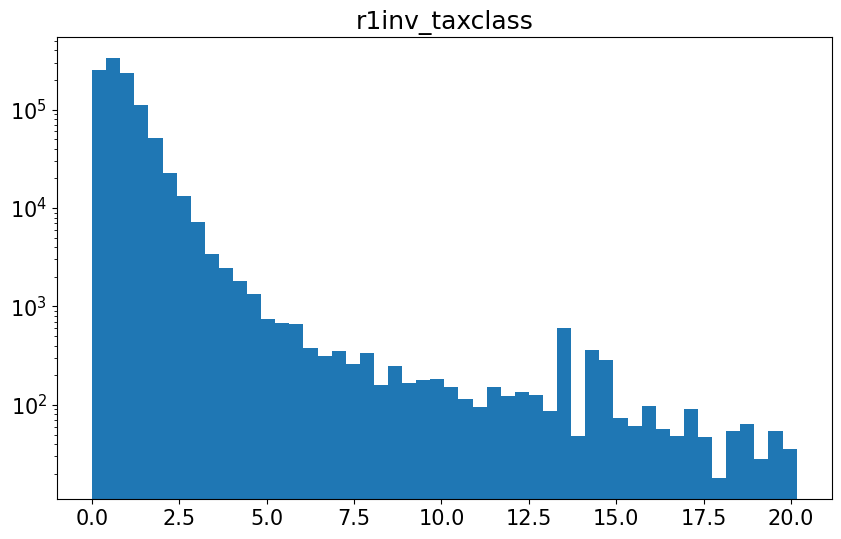

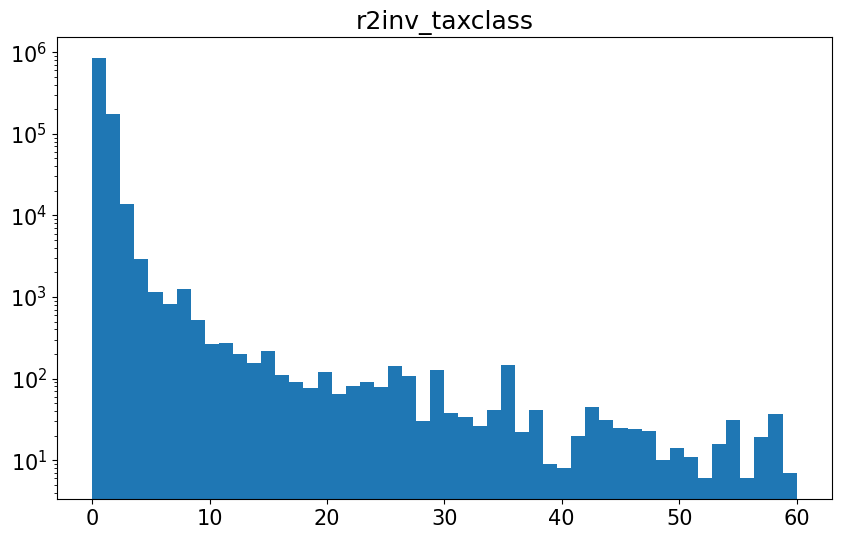

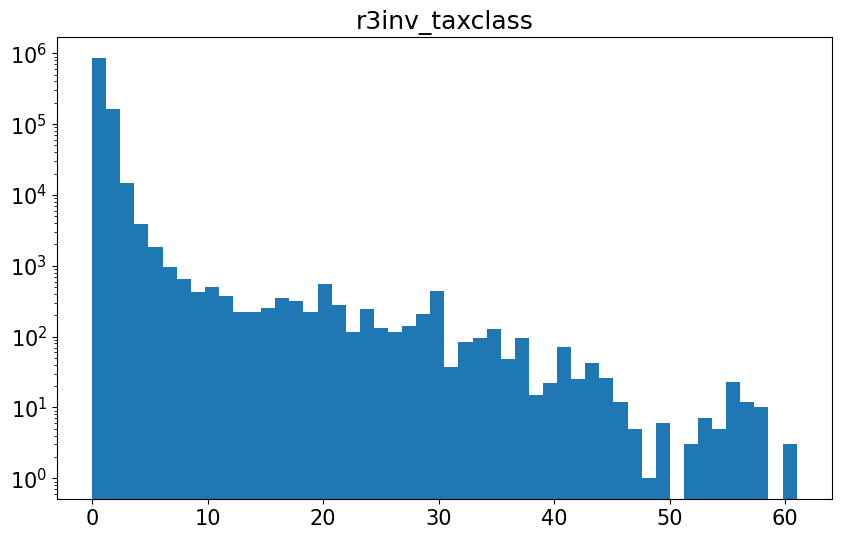

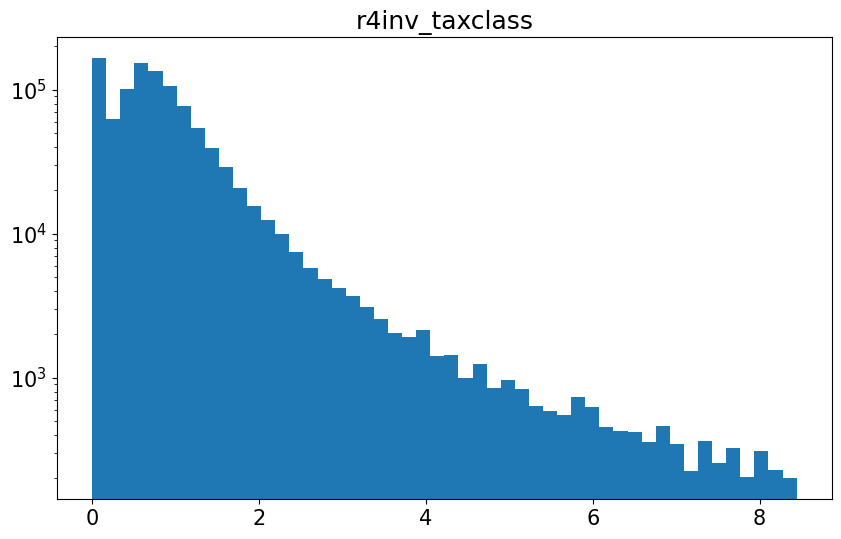

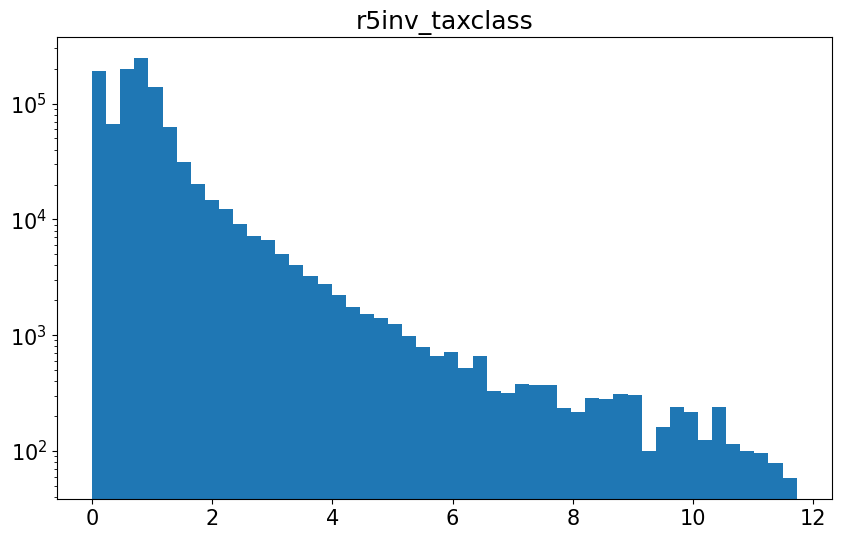

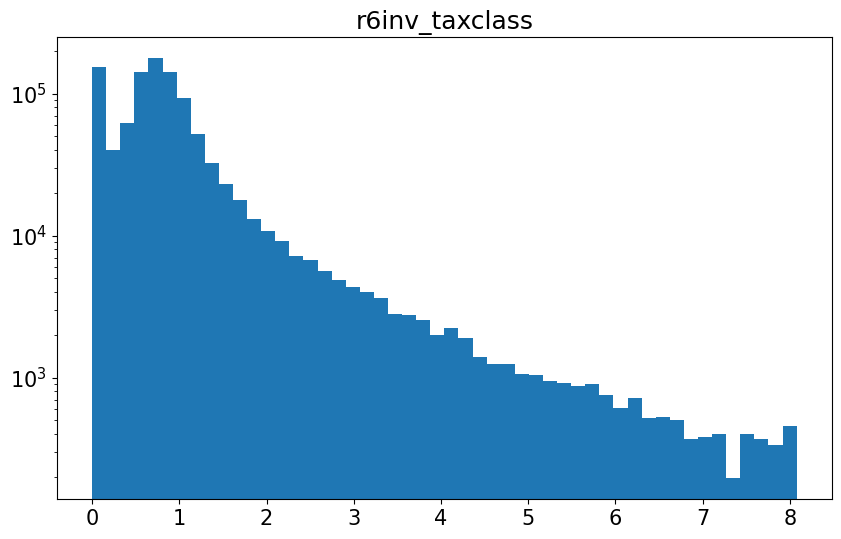

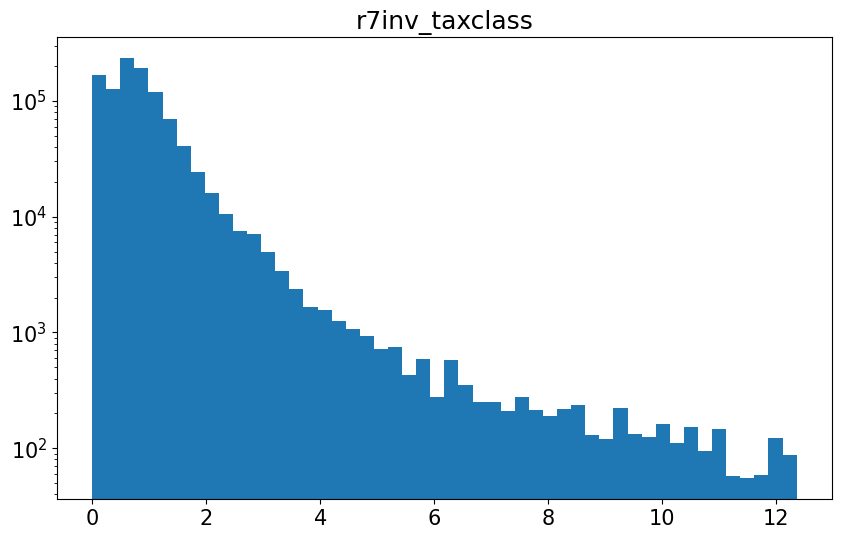

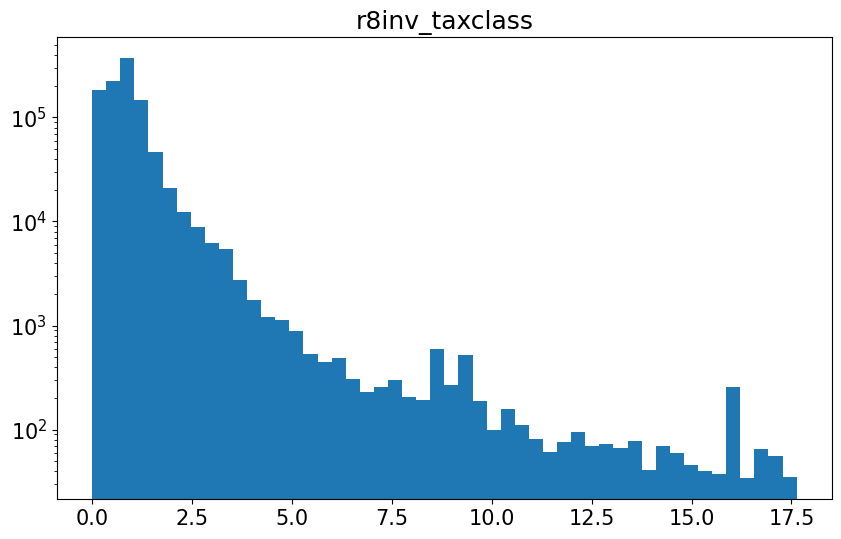

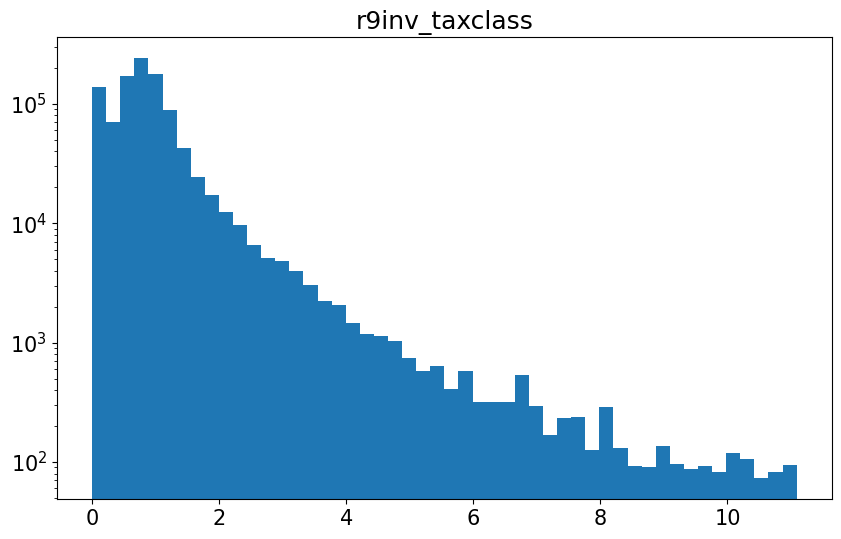

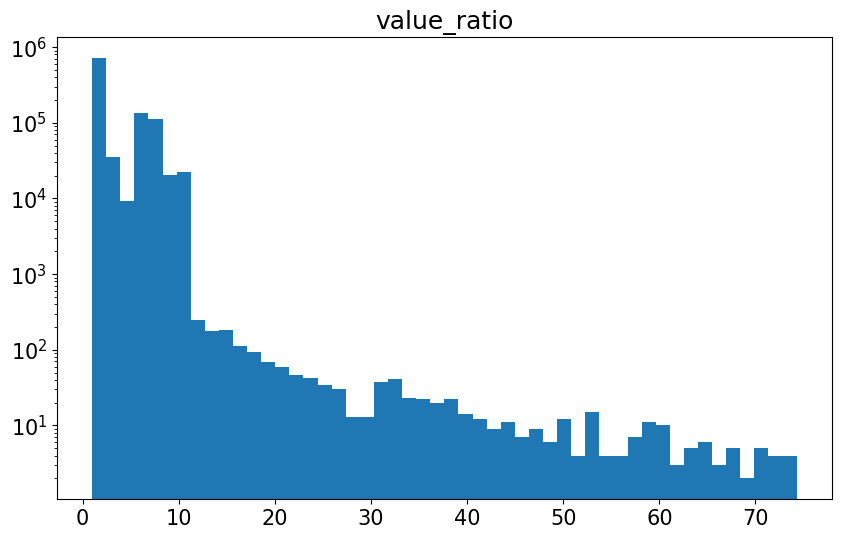

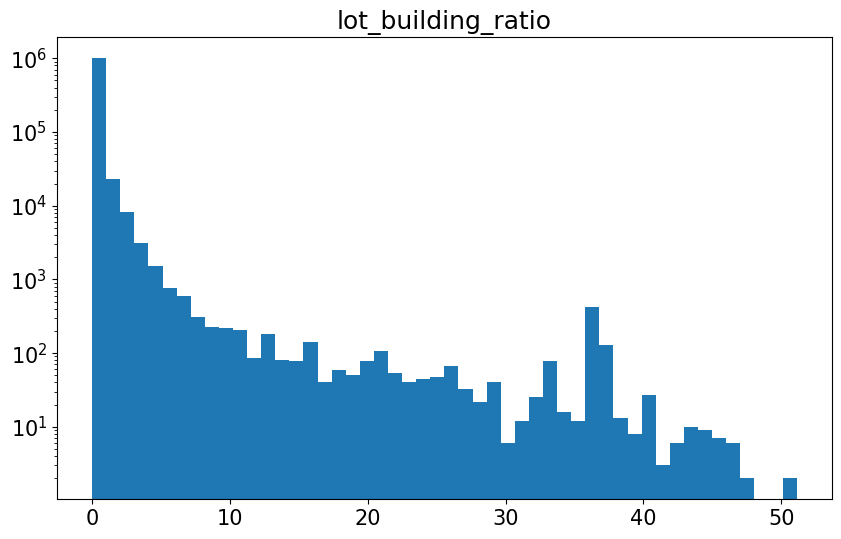

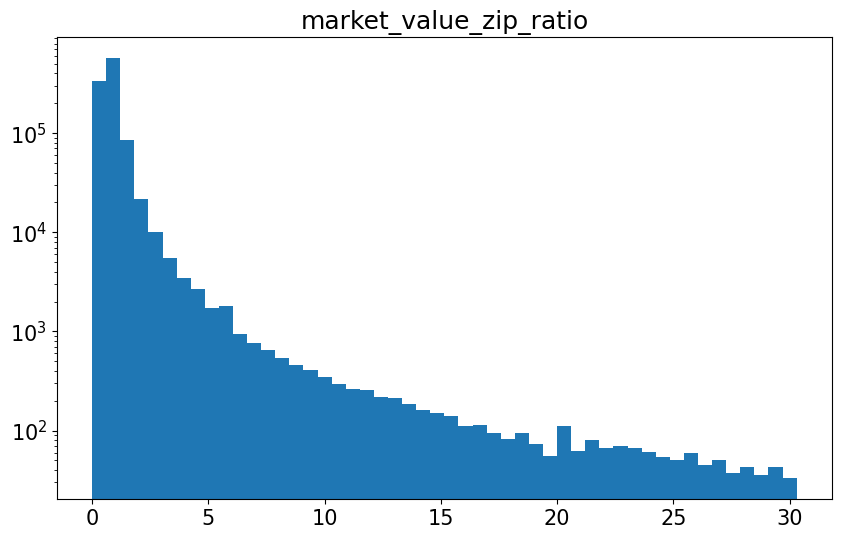

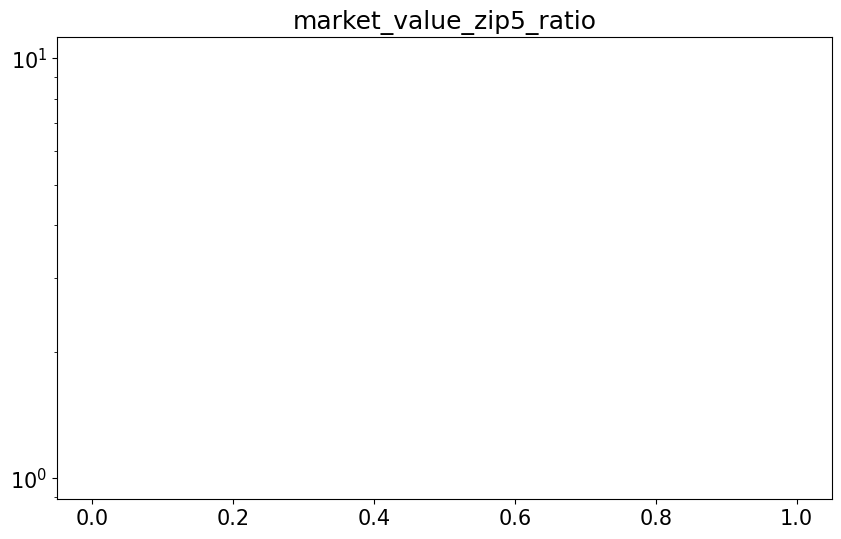

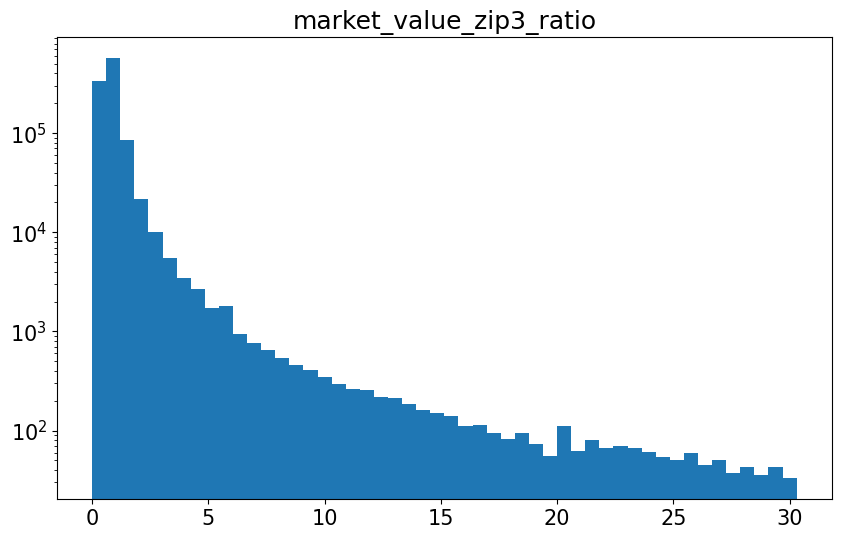

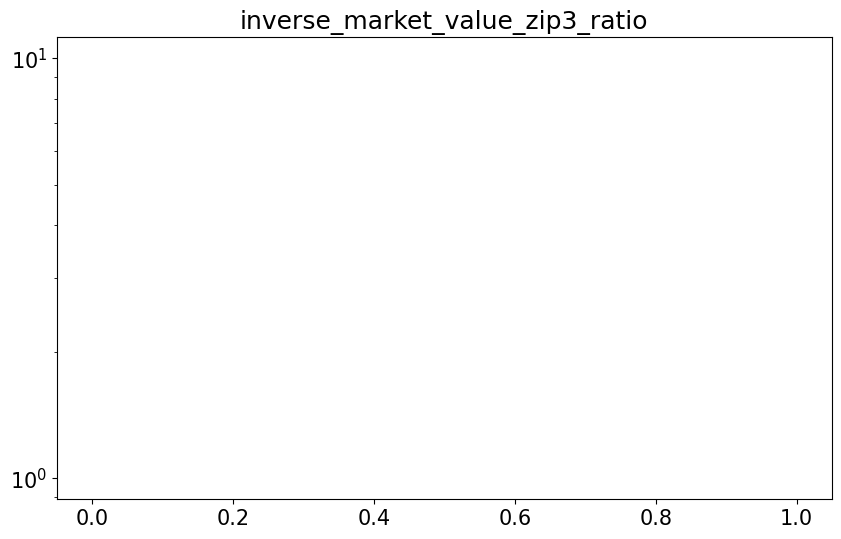

In [ ]:
%%time
nstd = 4
for col in data.columns:
    plt.rcParams['figure.figsize'] = [10,6]
    plt.figure()
    plt.rcParams['font.size'] = 15
    plt.yscale('log')
    xstdev = data[col].std()
    xmean = data[col].mean()
    temp = data[data[col] <= xmean + nstd*xstdev]
    temp = temp[data[col] >= xmean - nstd*xstdev]
    plt.hist(temp[col],bins=50)
    plt.title(col)

In [ ]:
data.shape

(1043806, 60)

In [ ]:
data.to_csv('NY vars.csv', index=False)

In [ ]:
# zscale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio,lot_building_ratio,market_value_zip_ratio,market_value_zip5_ratio,market_value_zip3_ratio,inverse_market_value_zip3_ratio
count,1.043806e+06,1.041442e+06,1.041442e+06,1.043806e+06,1.041442e+06,1.041442e+06,1.043806e+06,1.041442e+06,1.041442e+06,1.043806e+06,...,1.041442e+06,1.043806e+06,1.041442e+06,1.041442e+06,1.043806e+06,1.041442e+06,1.043806e+06,0.0,1.043806e+06,0.0
mean,-3.843090e-16,-2.484821e-17,1.515727e-16,7.515182e-18,2.531897e-17,1.742513e-17,-5.227953e-17,-1.591049e-17,-1.206591e-17,3.368217e-17,...,7.079215e-17,4.737832e-17,-6.549775e-18,-3.280345e-17,-4.421977e-17,8.466948e-18,-2.850868e-17,NaN,-2.850868e-17,NaN
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00,NaN
min,-3.969717e-01,-3.314036e-01,-4.166407e-01,-1.353135e-01,-3.537364e-02,-4.460685e-02,-1.300157e-01,-4.640922e-02,-5.288996e-02,-9.378067e-02,...,-5.648799e-01,-3.521591e-01,-2.404244e-01,-3.959601e-01,-1.183199e-01,-4.788205e-02,-1.364963e-01,NaN,-1.364963e-01,NaN
25%,-2.551629e-01,-2.019786e-01,-2.761501e-01,-1.050343e-01,-2.606229e-02,-3.567745e-02,-1.043063e-01,-3.053052e-02,-3.314559e-02,-8.919290e-02,...,-2.865811e-01,-1.936705e-01,-1.072452e-01,-1.847265e-01,-1.114811e-01,-2.767616e-02,-6.840936e-02,NaN,-6.840936e-02,NaN
50%,-1.126887e-01,-2.356209e-02,-9.616184e-03,-7.614501e-02,-1.275797e-02,-1.270548e-02,-8.827967e-02,-2.186048e-02,-1.745917e-02,-8.648057e-02,...,-1.370482e-01,-9.349194e-02,-5.000705e-02,-8.307651e-02,-1.024474e-01,-1.638129e-02,-3.296688e-02,NaN,-3.296688e-02,NaN
75%,5.510531e-02,8.932993e-02,1.552446e-01,-4.236276e-02,-4.769256e-03,1.757486e-04,-6.431552e-02,-1.369363e-02,-3.844207e-03,-7.913929e-02,...,3.975399e-02,3.605948e-02,1.450011e-02,3.000612e-02,1.642599e-01,3.453620e-03,3.530406e-05,NaN,3.530406e-05,NaN
max,2.629424e+02,7.107679e+02,3.872033e+02,3.293316e+02,7.591323e+02,5.023372e+02,3.215277e+02,8.004684e+02,8.193088e+02,1.074043e+02,...,3.608699e+02,2.131605e+02,4.759731e+02,4.336487e+02,5.605866e+02,8.034216e+02,4.766605e+02,NaN,4.766605e+02,NaN


In [ ]:
# do a PCA and look at the cumulative variance plot
#pca = PCA(n_components = .99, svd_solver = 'full')
#pca.fit(data_zs)
#plt.plot(pca.explained_variance_ratio_)
#plt.xlabel('Number of components minus 1')
#plt.ylabel('PC variance')
#plt.xticks(np.arange(0, 36, step=2))
#plt.axvline(x=4, linestyle='--')

In [ ]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')
plt.ylim(0,1)

In [ ]:
%%time
# now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 5, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

In [ ]:
print(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

In [ ]:
data_pca.head(5)

In [ ]:
data_pca.describe()

In [ ]:
# zscale the pcs. This is an optional step, and I like to make all the retained PCs equally important.
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

In [ ]:
data_pca_zs.shape

In [ ]:
data_pca_zs.head(5)

## Now calculate two unsupervised fraud scores

In [ ]:
# Set the powers for the two Minkowski distances. The final results are relatively insensitive to these choices.
# Good choices are anywhere from 1 to about 4.
p1 = 2
p2 = 2
ntop = 1000

### Calculate score 1

In [ ]:
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

In [ ]:
data_pca_zs.head(10)

In [ ]:
score1.max()

### Autoencoder for score 2

In [ ]:
%%time
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=50,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)

In [ ]:
# calculate score 2 as the error of an autoencoder
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

In [ ]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

In [ ]:
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

In [ ]:
# calculate the final score as the average of the two scores
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])
scores_sorted = scores.sort_values(by='final', ascending=False)
scores.head(20)

In [ ]:
scores_sorted.head(10)

In [ ]:
scores_sorted.tail(10)

In [ ]:
scores.describe()

In [ ]:
scores_sorted.describe()

In [ ]:
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(10)

In [ ]:
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

In [ ]:
sc2max = int(score2.max())
sc2max

In [ ]:
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

In [ ]:
plt.hist(scores['final'],bins=100)

In [ ]:
top_records = scores_sorted.head(ntop).index
print(top_records)

In [ ]:
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

In [ ]:
data_zs_top_n = data_zs.loc[top_records]
data_zs_top_n.transpose()

In [ ]:
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

In [ ]:
# NY_data_with_scores = NY_data_orig.join(scores, on='RECORD', rsuffix='_scores')
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores

In [ ]:
NY_data_scored_and_sorted = NY_data_with_scores.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_scored_and_sorted.set_index('RECORD',inplace=True)
NY_data_top_n = NY_data_scored_and_sorted.head(ntop)
NY_data_top_n

In [ ]:
NY_data_with_scores.head(10)

In [ ]:
NY_data_top_n['OWNER'].head(40)

In [ ]:
NY_data_top_n.shape

In [ ]:
data_zs_top_n.shape

In [ ]:
NY_top_with_zs = pd.concat([NY_data_top_n,data_zs_top_n],axis=1)
NY_top_with_zs.shape

In [ ]:
NY_top_with_zs.to_excel('NY_top_with_zs.xlsx', index=True)
NY_data_top_n.to_excel('NY_top.xlsx', index=True)
data_zs_top_n.to_csv('data_zs_top.csv', index=True)

In [ ]:
data_zs_top_n.shape

In [ ]:
# The heatmaps are good for seeing which variables are driving the high scores
data_base_vars = data_zs_top_n.iloc[:,0:17].abs()
data_heatmap = data_base_vars.head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [ ]:
data_zs_top_n_abs = data_zs_top_n.abs()
data_heatmap = data_zs_top_n.abs().head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [ ]:
top_records_df = pd.DataFrame(top_records)

In [ ]:
# Use this cell if you want to write out the top n record numbers
top_records_df.to_csv('top_n_record_numbers.csv', index=False)

In [ ]:
# # Use this cell if you want to compare to a previous top n record numbers.
# # You can run a baseline model, see which records score the highest, then change some of the algorithm parameters
# # to see what % of these top scoring records change. The top records are insensitive to changes in the
# # powers for the Minkowski distance measures for the two scores

# top_records_previous = pd.read_csv('top_n_record_numbers.csv')
# print(top_records_df.head())
# print(top_records_previous.head())
# num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
# percent_common = 100*num_common/ntop
# percent_common

In [ ]:
# about 4 minutes
print('Duration: ', datetime.now() - start_time)